# SETTING UP DINO AND EVALUATION DINO MODEL

In [ ]:

"""
Install all required packages and verify the environment
"""
print("=== Installing Dependencies ===")

# Install PyTorch and vision
!pip install torch torchvision
!pip install -r "/content/drive/MyDrive/CV/CV_assignment/DINO/requirements.txt"

# Install additional requirements
!pip install submitit
!pip install scipy
!pip install timm
!pip install numpy
!pip install pycocotools
!pip install opencv-python
!pip install pandas
!pip install tqdm

# Basic imports
import os
import sys
import torch
import numpy as np
import cv2
from PIL import Image
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Verify environment
print("\n=== Environment Check ===")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

print("\nDependencies installed successfully!")


=== Installing Dependencies ===
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-lwf94oxj/pycocotools_b4f6549bd7434d91b0f5d58e995c35c2
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-install-lwf94oxj/pycocotools_b4f6549bd7434d91b0f5d58e995c35c2
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-lwf94oxj/panopticapi_b4b39430079c4b40ada22ee6214b108b
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-lwf94oxj/panopticapi_b4b39430079c4b40ada22ee6214b108b
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.6 MB/s eta 

In [ ]:
"""
Build and verify the CUDA operations required for DINO
"""
print("=== Building CUDA Operations ===")

import os
import sys
import shutil
import glob

# Add DINO to Python path
dino_path = "/content/drive/MyDrive/CV/CV_assignment/DINO"
if dino_path not in sys.path:
    sys.path.append(dino_path)
print("Added DINO to Python path")

# Clean previous builds
ops_path = "/content/drive/MyDrive/CV/CV_assignment/DINO/models/dino/ops"
build_path = os.path.join(ops_path, "build")
if os.path.exists(build_path):
    print("Cleaning previous build...")
    shutil.rmtree(build_path)

# Set environment variables
os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'  # For T4 GPU

# Build operations
print("\nBuilding CUDA operations...")
%cd "/content/drive/MyDrive/CV/CV_assignment/DINO/models/dino/ops"
!python setup.py build install --user

# Return to original directory
%cd "/content/drive/MyDrive/CV/CV_assignment"

# Add paths
build_dir = glob.glob(os.path.join(ops_path, "build/lib.*"))[0]
if build_dir not in sys.path:
    sys.path.append(build_dir)

local_site_packages = "/root/.local/lib/python3.10/site-packages"
if local_site_packages not in sys.path:
    sys.path.append(local_site_packages)

# Verify installation
print("\nVerifying CUDA operations...")
try:
    import MultiScaleDeformableAttention
    print("✓ MultiScaleDeformableAttention imported successfully!")
except Exception as e:
    print(f"✗ Import failed: {str(e)}")
    raise



=== Building CUDA Operations ===
Added DINO to Python path
Cleaning previous build...

Building CUDA operations...
/content/drive/MyDrive/CV/CV_assignment/DINO/models/dino/ops
running build
running build_py
creating build/lib.linux-x86_64-cpython-310/modules
copying modules/__init__.py -> build/lib.linux-x86_64-cpython-310/modules
copying modules/ms_deform_attn.py -> build/lib.linux-x86_64-cpython-310/modules
creating build/lib.linux-x86_64-cpython-310/functions
copying functions/__init__.py -> build/lib.linux-x86_64-cpython-310/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-310/functions
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:497: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:416

In [ ]:

"""
Set up DINO model configuration and build the model
"""
print("=== Setting up Model Configuration ===")

import sys
sys.path.append("/content/drive/MyDrive/CV/CV_assignment/DINO")

# Import required modules
from models.dino.dino import build_dino
from util.slconfig import SLConfig
from util.misc import NestedTensor
from datasets import build_dataset
from util.visualizer import COCOVisualizer

def create_model_config():
    """Create and configure model parameters"""
    print("\nCreating model configuration...")

    # Load base config
    config_path = "/content/drive/MyDrive/CV/CV_assignment/DINO/config/DINO/DINO_4scale.py"
    args = SLConfig.fromfile(config_path)

    # Modify for pedestrian detection
    args.num_classes = 2  # background + pedestrian
    args.dn_labelbook_size = 2
    args.device = 'cuda'

    # Set model parameters
    args.hidden_dim = 256
    args.num_queries = 900
    args.num_feature_levels = 4
    args.enc_layers = 6
    args.dec_layers = 6
    args.dim_feedforward = 2048

    print("✓ Configuration created successfully")
    return args

def build_and_load_model(args):
    """Build DINO model and load weights"""
    print("\nBuilding model...")
    model, criterion, postprocessors = build_dino(args)

    print("Loading checkpoint...")
    checkpoint = torch.load('/content/drive/MyDrive/CV/CV_assignment/checkpoint0011_4scale.pth',
                          map_location='cuda')

    print("Processing weights...")
    model_weights = checkpoint['model']
    processed_weights = {}

    for k, v in model_weights.items():
        if 'class_embed' in k:
            if v.shape[0] == 91:
                new_weight = torch.zeros(2, *v.shape[1:], device=v.device)
                new_weight[0] = v[0]  # background
                new_weight[1] = v[1]  # person/pedestrian
                processed_weights[k] = new_weight
        elif 'label_enc.weight' in k:
            if v.shape[0] == 92:
                new_weight = torch.zeros(3, v.shape[1], device=v.device)
                new_weight[0] = v[0]
                new_weight[1] = v[1]
                new_weight[2] = v[-1]
                processed_weights[k] = new_weight
        else:
            processed_weights[k] = v

    print("Loading processed weights into model...")
    model.load_state_dict(processed_weights, strict=False)
    model.eval()
    model.cuda()

    print("✓ Model built and loaded successfully")
    return model, postprocessors

# Create configuration and build model
args = create_model_config()
model, postprocessors = build_and_load_model(args)



=== Setting up Model Configuration ===


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



Creating model configuration...
✓ Configuration created successfully

Building model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


Loading checkpoint...


<ipython-input-3-8515c307de10>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/CV/CV_assignment/checkpoint0011_4scale.pth',

Processing weights...
Loading processed weights into model...
✓ Model built and loaded successfully


In [ ]:
"""
Process validation images and run inference
"""
print("=== Running Inference on Validation Images ===")

import torchvision.transforms as T

def create_transform():
    """Create image transformation pipeline"""
    return T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def run_inference():
    """Run inference on validation images"""
    transform = create_transform()
    validation_dir = "/content/drive/MyDrive/CV/CV_assignment/validation"
    output_dir = "/content/drive/MyDrive/CV/CV_assignment/DINO_output"
    os.makedirs(output_dir, exist_ok=True)

    results = []
    validation_files = [f for f in os.listdir(validation_dir)
                       if f.endswith(('.jpg', '.jpeg', '.png'))]

    print(f"\nProcessing {len(validation_files)} validation images...")

    for idx, img_file in enumerate(validation_files, 1):
        img_path = os.path.join(validation_dir, img_file)
        image = Image.open(img_path).convert('RGB')
        orig_size = image.size

        # Prepare image
        img_tensor = transform(image).unsqueeze(0).cuda()
        mask = torch.zeros(1, img_tensor.shape[2], img_tensor.shape[3],
                         dtype=torch.bool).cuda()
        nested_tensor = NestedTensor(img_tensor, mask)

        # Run inference
        with torch.no_grad():
            outputs = model(nested_tensor)

        # Post-process
        processed = postprocessors['bbox'](outputs,
                                        torch.tensor([[orig_size[1], orig_size[0]]]).cuda())[0]

        # Filter predictions
        scores = processed['scores']
        boxes = processed['boxes']
        labels = processed['labels']

        keep = scores > 0.3
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        # Store results
        results.append({
            'image_id': img_file,
            'boxes': boxes.cpu().numpy(),
            'scores': scores.cpu().numpy(),
            'labels': labels.cpu().numpy()
        })

        # Visualize
        image_np = np.array(image)
        for box, score in zip(boxes.cpu(), scores.cpu()):
            x1, y1, x2, y2 = box.tolist()
            cv2.rectangle(image_np,
                         (int(x1), int(y1)),
                         (int(x2), int(y2)),
                         (0, 255, 0), 2)
            cv2.putText(image_np,
                       f'pedestrian {score:.2f}',
                       (int(x1), int(y1)-10),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.5,
                       (0, 255, 0),
                       2)

        # Save visualization
        output_path = os.path.join(output_dir, f'pred_{img_file}')
        cv2.imwrite(output_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

        print(f"[{idx}/{len(validation_files)}] Processed {img_file} - "
              f"found {len(boxes)} detections")

    print("\n✓ Inference completed successfully!")
    return results

# Run inference
results = run_inference()


=== Running Inference on Validation Images ===

Processing 40 validation images...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1/40] Processed 8794.jpg - found 2 detections
[2/40] Processed 6276.jpg - found 6 detections
[3/40] Processed 10990.jpg - found 9 detections
[4/40] Processed 11273.jpg - found 4 detections
[5/40] Processed 13038.jpg - found 4 detections
[6/40] Processed 1901.jpg - found 13 detections
[7/40] Processed 16128.jpg - found 3 detections
[8/40] Processed 11953.jpg - found 8 detections
[9/40] Processed 11303.jpg - found 4 detections
[10/40] Processed 5303.jpg - found 2 detections
[11/40] Processed 14264.jpg - found 11 detections
[12/40] Processed 7452.jpg - found 6 detections
[13/40] Processed 11002.jpg - found 11 detections
[14/40] Processed 11080.jpg - found 4 detections
[15/40] Processed 6879.jpg - found 18 detections
[16/40] Processed 7002.jpg - found 16 detections
[17/40] Processed 13187.jpg - found 8 detections
[18/40] Processed 8468.jpg - found 6 detections
[19/40] Processed 14251.jpg - found 7 detections
[20/40] Processed 11588.jpg - found 8 detections
[21/40] Processed 15656.jpg - fo

In [ ]:
"""
Calculate AP metrics and perform detailed analysis with numpy float64
"""
print("=== Calculating AP Metrics and Detailed Analysis ===")

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import datetime  # Required for the patched COCOeval

# First, create a patched version of COCOeval

class PatchedCOCOeval(COCOeval):
    def accumulate(self):
        """
        Modified accumulate function that fixes broadcasting and numpy float issues
        """
        print('Accumulating evaluation results...')
        if not self.evalImgs:
            print('Please run evaluate() first')
            return

        # Initialize
        p = self.params
        catIds = p.catIds if p.useCats else [-1]
        T = len(p.iouThrs)
        R = len(p.recThrs)
        K = len(catIds) if p.useCats else 1
        A = len(p.areaRng)
        M = len(p.maxDets)

        precision = -np.ones((T, R, K, A, M))  # -1 for the precision of absent categories
        recall = -np.ones((T, K, A, M))
        scores = -np.ones((T, R, K, A, M))

        # retrieve E at each category, area range, and max number of detections
        for k, k_cat in enumerate(catIds):
            E = [self.evalImgs[i] for i in range(len(self.evalImgs))]
            E = [e for e in E if e is not None]
            if len(E) == 0:
                continue

            # accumulate per image evaluation results
            dtScores = np.concatenate([e['dtScores'][0:p.maxDets[-1]] for e in E])

            # different sorting method generates slightly different results.
            # mergesort is used to be consistent as Matlab implementation.
            inds = np.argsort(-dtScores, kind='mergesort')
            dtScoresSorted = dtScores[inds]

            dtm = np.concatenate([e['dtMatches'][:, 0:p.maxDets[-1]] for e in E], axis=1)[:, inds]
            dtIg = np.concatenate([e['dtIgnore'][:, 0:p.maxDets[-1]] for e in E], axis=1)[:, inds]
            gtIg = np.concatenate([e['gtIgnore'] for e in E])
            npig = np.count_nonzero(gtIg == 0)

            if npig == 0:
                continue

            tps = np.logical_and(dtm, np.logical_not(dtIg))
            fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg))

            tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float64)
            fp_sum = np.cumsum(fps, axis=1).astype(dtype=np.float64)

            for t, (tp, fp) in enumerate(zip(tp_sum, fp_sum)):
                tp = np.array(tp)
                fp = np.array(fp)
                nd = len(tp)
                rc = tp / npig
                pr = tp / (fp + tp + np.spacing(1))
                q = np.zeros((R,))

                if nd:
                    recall[t, k, :, M-1] = rc[-1]
                else:
                    recall[t, k, :, M-1] = 0

                # numpy is slow without cython optimization for accessing elements
                # use python array gets significant speed improvement
                pr = pr.tolist()
                q = q.tolist()

                for i in range(nd-1, 0, -1):
                    if pr[i] > pr[i-1]:
                        pr[i-1] = pr[i]

                inds = np.searchsorted(rc, p.recThrs, side='left')
                try:
                    for ri, pi in enumerate(inds):
                        q[ri] = pr[pi]
                except:
                    pass

                # Fix broadcasting: Expand q to match precision dimensions
                precision[t, :, k, :, M-1] = np.array(q)[:, None]

        self.eval = {
            'params': p,
            'counts': [T, R, K, A, M],
            'date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'precision': precision,
            'recall':   recall,
            'scores': scores,
        }


def calculate_ap_detailed():
    """Calculate AP metrics with detailed analysis"""
    output_dir = "/content/drive/MyDrive/CV/CV_assignment/DINO_output"
    os.makedirs(output_dir, exist_ok=True)

    # Load ground truth
    print("\nLoading ground truth annotations...")
    gt_path = "/content/drive/MyDrive/CV/CV_assignment/random_sample_mavi_2_gt.json"
    with open(gt_path, 'r') as f:
        gt_data = json.load(f)

    id_mapping = {img['file_name']: img['id'] for img in gt_data['images']}
    print(f"Found {len(id_mapping)} images in ground truth")

    # Format predictions
    print("\nFormatting predictions...")
    coco_predictions = []
    score_distribution = []
    box_sizes = []

    for result in results:
        if result['image_id'] not in id_mapping:
            continue

        image_id = id_mapping[result['image_id']]
        boxes = result['boxes']
        scores = result['scores']

        # Collect statistics
        score_distribution.extend(scores.tolist())

        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            area = width * height
            box_sizes.append(float(area))

            coco_predictions.append({
                'image_id': image_id,
                'category_id': 1,
                'bbox': [float(x1), float(y1), float(width), float(height)],
                'score': float(score)
            })

    print(f"Processed {len(coco_predictions)} predictions")

    # Initialize COCO evaluation with patched version
    print("\nInitializing COCO evaluation...")
    cocoGt = COCO(gt_path)
    cocoDt = cocoGt.loadRes(coco_predictions)
    cocoEval = PatchedCOCOeval(cocoGt, cocoDt, 'bbox')  # Using patched version

    # Set validation image IDs
    val_img_ids = [id_mapping[result['image_id']] for result in results
                   if result['image_id'] in id_mapping]
    cocoEval.params.imgIds = val_img_ids

    # Run evaluation
    print("\nRunning COCO evaluation...")
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    # Calculate per-image results
    print("\nCalculating detailed per-image metrics...")
    per_image_results = {}
    density_stats = []

    for result in results:
        filename = result['image_id']
        if filename not in id_mapping:
            continue

        img_id = id_mapping[filename]
        ann_ids = cocoGt.getAnnIds(imgIds=[img_id])
        gt_anns = cocoGt.loadAnns(ann_ids)
        pred_anns = [p for p in coco_predictions if p['image_id'] == img_id]

        num_gt = len(gt_anns)
        num_pred = len(pred_anns)
        detection_ratio = num_pred / num_gt if num_gt > 0 else 0

        img_info = next(img for img in gt_data['images'] if img['id'] == img_id)
        area = img_info['width'] * img_info['height']
        density = num_gt / area if area > 0 else 0

        per_image_results[filename] = {
            'num_gt': num_gt,
            'num_pred': num_pred,
            'detection_ratio': float(detection_ratio),
            'density': float(density),
            'area': float(area)
        }

        density_stats.append({
            'filename': filename,
            'density': float(density),
            'detection_ratio': float(detection_ratio)
        })

    # Extract metrics
    metrics = {
        'AP@0.5': float(cocoEval.stats[1]),
        'AP@0.75': float(cocoEval.stats[2]),
        'AP (mean)': float(cocoEval.stats[0]),
        'AR@100': float(cocoEval.stats[8]),
        'Score_Mean': float(np.mean(score_distribution)),
        'Score_Std': float(np.std(score_distribution)),
        'BoxSize_Mean': float(np.mean(box_sizes)),
        'BoxSize_Std': float(np.std(box_sizes))
    }

    # Save results
    print("\nSaving detailed results...")
    output_data = {
        'overall_metrics': metrics,
        'per_image_results': per_image_results,
        'summary': {
            'total_images': len(val_img_ids),
            'total_predictions': len(coco_predictions),
            'total_ground_truth': sum(len(cocoGt.getAnnIds(imgIds=[img_id]))
                                    for img_id in val_img_ids)
        }
    }

    output_file = os.path.join(output_dir, "evaluation_results.json")
    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=2)

    print(f"\nDetailed results saved to: {output_file}")
    print("\n=== Overall Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    return metrics, per_image_results, score_distribution, box_sizes, density_stats

# Calculate detailed AP
try:
    metrics, per_image_results, scores, box_sizes, density_stats = calculate_ap_detailed()
except Exception as e:
    print(f"\nError during calculation: {str(e)}")
    import traceback
    traceback.print_exc()


=== Calculating AP Metrics and Detailed Analysis ===

Loading ground truth annotations...
Found 199 images in ground truth

Formatting predictions...
Processed 278 predictions

Initializing COCO evaluation...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

Running COCO evaluation...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430
 Ave

=== Analyzing Results ===

=== Detailed Analysis Results ===

1. Overall Statistics:
Total images analyzed: 40
Total ground truth objects: 310
Total predictions: 278
Average Detection Ratio: 0.949
Median Detection Ratio: 1.000
Detection Ratio Std: 0.190

2. Performance Categories:
Perfect Detections (within 5%): 15 images (37.5%)
Over-detections (>105%): 7 images (17.5%)
Under-detections (<95%): 18 images (45.0%)

3. Most Challenging Cases:

Images with most missed detections (lowest detection ratio):

Image: 1901.jpg
  Ground Truth: 23.0
  Predictions: 13.0
  Detection Ratio: 0.565
  Density: 0.000075

Image: 7002.jpg
  Ground Truth: 25.0
  Predictions: 16.0
  Detection Ratio: 0.640
  Density: 0.000081

Image: 15581.jpg
  Ground Truth: 3.0
  Predictions: 2.0
  Detection Ratio: 0.667
  Density: 0.000010

Image: 13038.jpg
  Ground Truth: 6.0
  Predictions: 4.0
  Detection Ratio: 0.667
  Density: 0.000020

Image: 13995.jpg
  Ground Truth: 7.0
  Predictions: 5.0
  Detection Ratio: 0.714
 

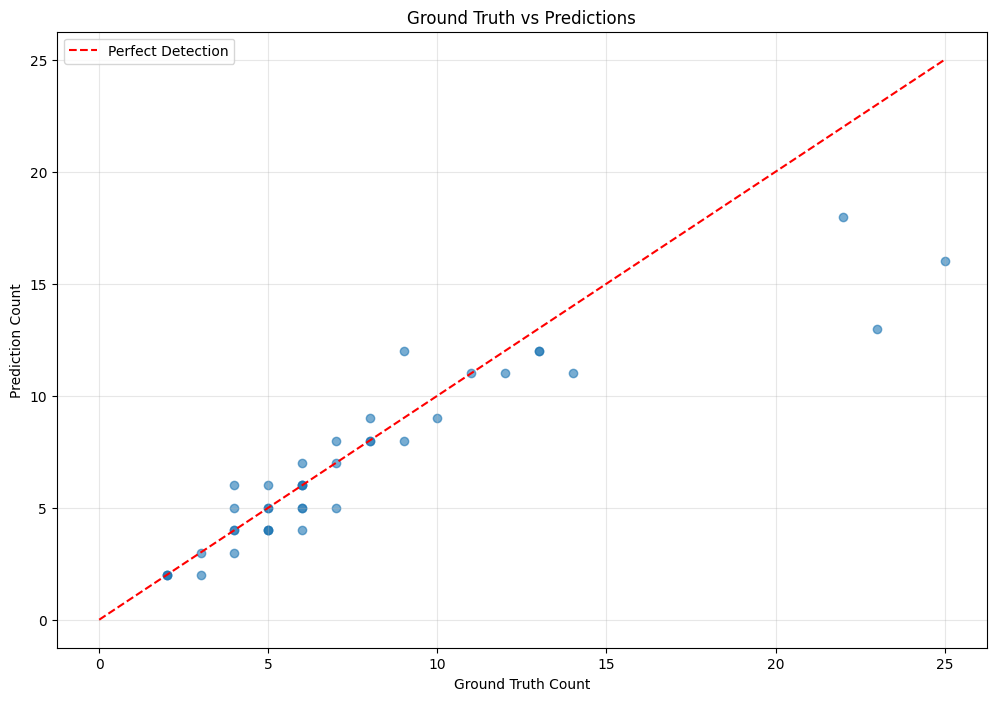


=== Visualization 2: Detection Ratio Distribution ===


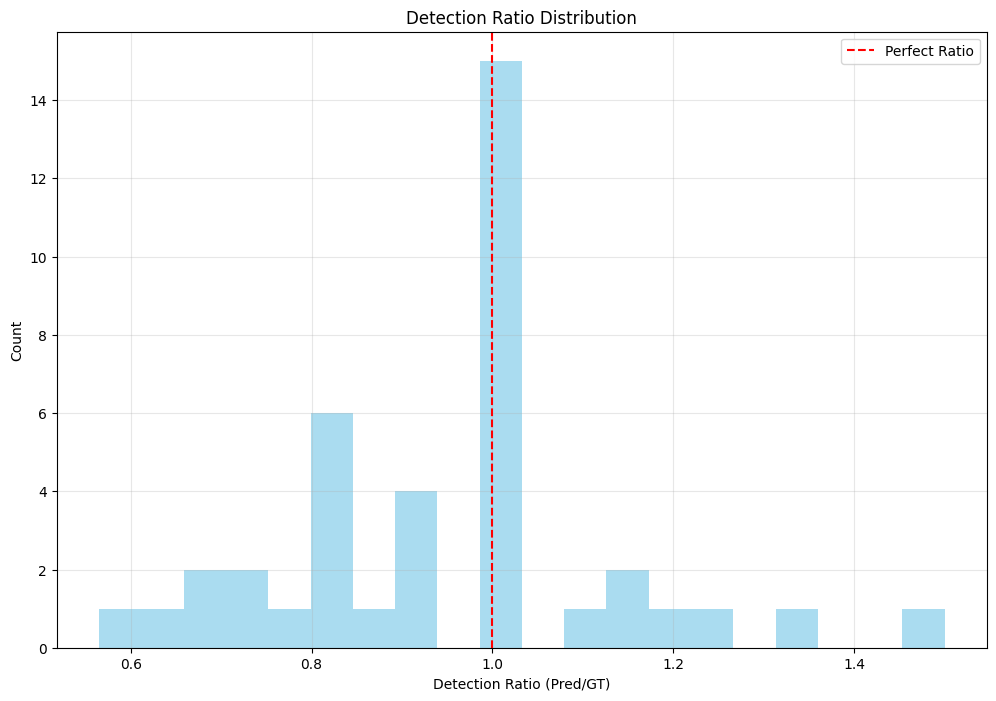


=== Visualization 3: Performance by Complexity (Bar Plot) ===


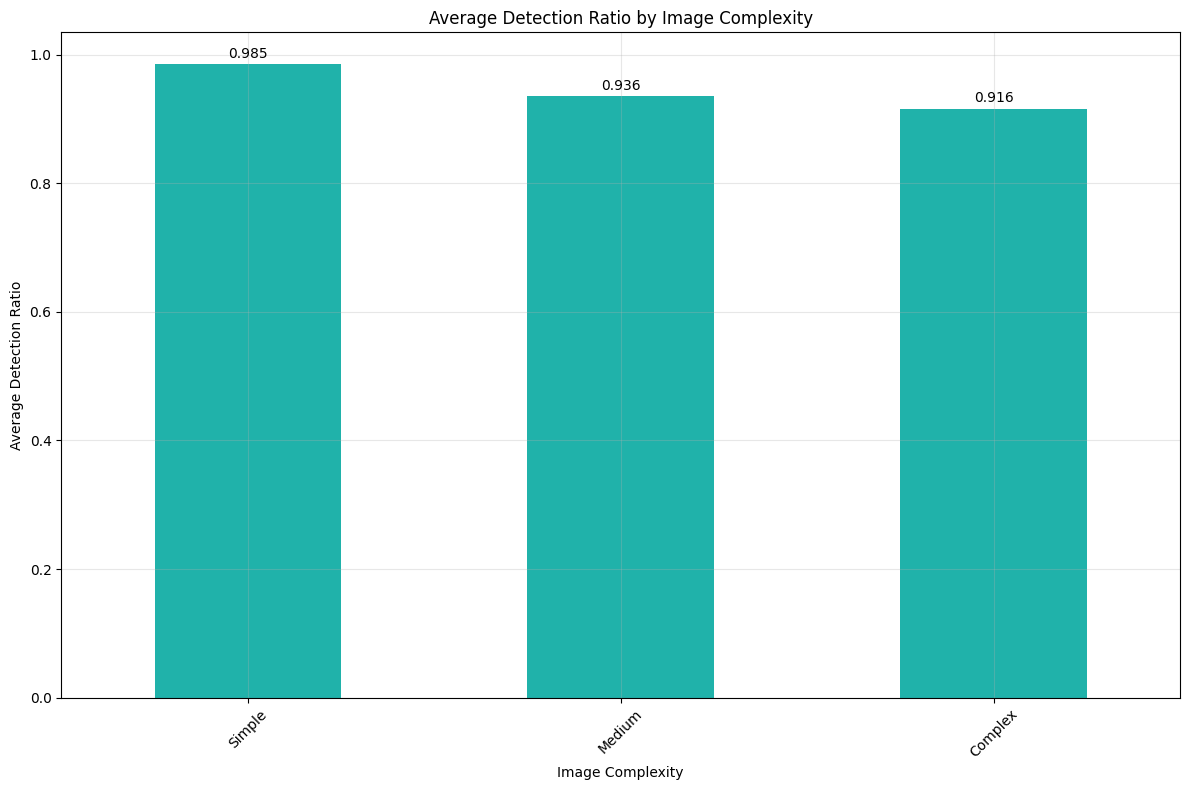


=== Visualization 4: Performance by Complexity (Box Plot) ===


<ipython-input-6-88330ca0afe1>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='complexity', y='detection_ratio', palette='Set3')


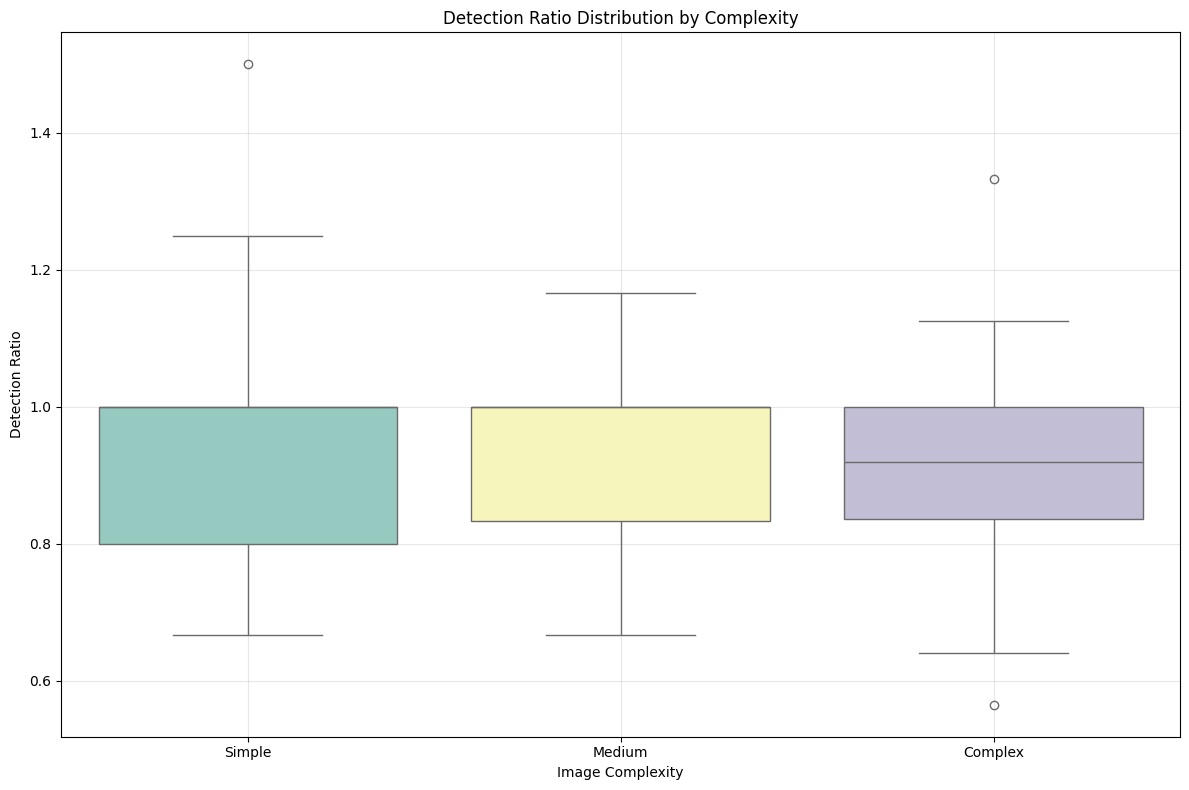


=== Visualization 5: Detection Performance Summary ===


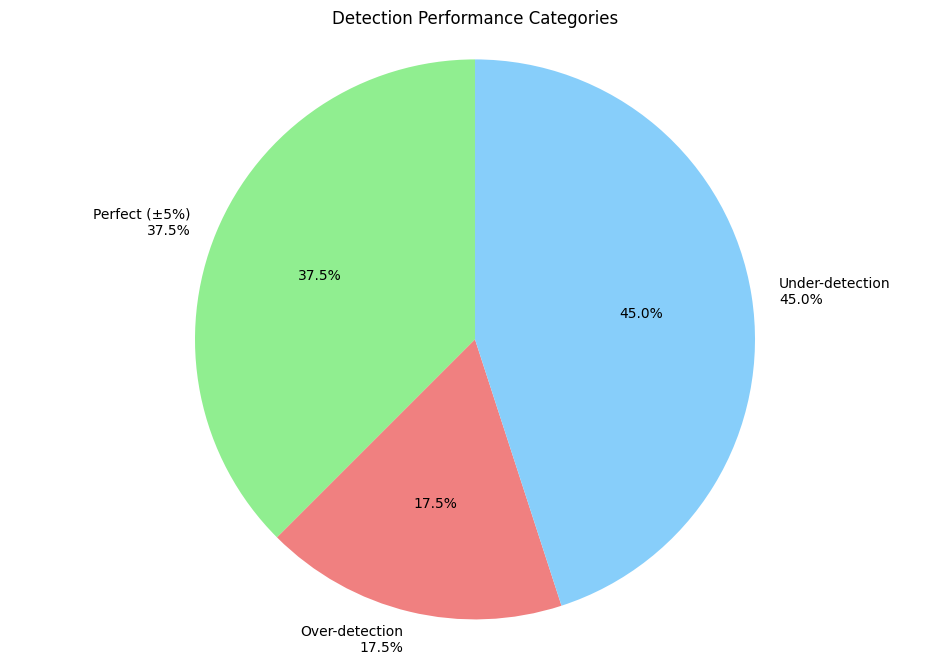


Visualization files saved:
1. gt_vs_pred.png - Ground Truth vs Predictions Scatter Plot
2. detection_ratio_dist.png - Detection Ratio Distribution Histogram
3. complexity_performance_bar.png - Performance by Complexity (Bar Plot)
4. complexity_performance_box.png - Performance by Complexity (Box Plot)
5. performance_summary_pie.png - Performance Categories Pie Chart

=== Analysis Complete ===


In [ ]:
"""
Analyze and visualize the detection results with individual visualizations
"""
print("=== Analyzing Results ===")

def create_and_display_visualizations(df, output_dir):
    """Create, save, and display individual visualization plots"""

    print("\n=== Visualization 1: Ground Truth vs Predictions ===")
    plt.figure(figsize=(12, 8))
    plt.scatter(df['num_gt'], df['num_pred'], alpha=0.6)
    max_val = max(df['num_gt'].max(), df['num_pred'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Detection')
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Prediction Count')
    plt.title('Ground Truth vs Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, "gt_vs_pred.png"))
    plt.show()
    plt.close()

    print("\n=== Visualization 2: Detection Ratio Distribution ===")
    plt.figure(figsize=(12, 8))
    df['detection_ratio'].hist(bins=20, alpha=0.7, color='skyblue')
    plt.axvline(x=1.0, color='r', linestyle='--', label='Perfect Ratio')
    plt.xlabel('Detection Ratio (Pred/GT)')
    plt.ylabel('Count')
    plt.title('Detection Ratio Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, "detection_ratio_dist.png"))
    plt.show()
    plt.close()

    print("\n=== Visualization 3: Performance by Complexity (Bar Plot) ===")
    plt.figure(figsize=(12, 8))
    complexity_means = df.groupby('complexity', observed=True)['detection_ratio'].mean()
    ax = complexity_means.plot(kind='bar', color='lightseagreen')
    plt.title('Average Detection Ratio by Image Complexity')
    plt.ylabel('Average Detection Ratio')
    plt.xlabel('Image Complexity')
    plt.xticks(rotation=45)
    for i, v in enumerate(complexity_means):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "complexity_performance_bar.png"))
    plt.show()
    plt.close()

    print("\n=== Visualization 4: Performance by Complexity (Box Plot) ===")
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='complexity', y='detection_ratio', palette='Set3')
    plt.title('Detection Ratio Distribution by Complexity')
    plt.ylabel('Detection Ratio')
    plt.xlabel('Image Complexity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "complexity_performance_box.png"))
    plt.show()
    plt.close()

    print("\n=== Visualization 5: Detection Performance Summary ===")
    # Create a pie chart of performance categories
    plt.figure(figsize=(12, 8))
    perfect = (abs(df['detection_ratio'] - 1) <= 0.05).sum()
    over = (df['detection_ratio'] > 1.05).sum()
    under = (df['detection_ratio'] < 0.95).sum()

    sizes = [perfect, over, under]
    labels = [f'Perfect (±5%)\n{perfect/len(df)*100:.1f}%',
              f'Over-detection\n{over/len(df)*100:.1f}%',
              f'Under-detection\n{under/len(df)*100:.1f}%']
    colors = ['lightgreen', 'lightcoral', 'lightskyblue']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90)
    plt.title('Detection Performance Categories')
    plt.axis('equal')
    plt.savefig(os.path.join(output_dir, "performance_summary_pie.png"))
    plt.show()
    plt.close()

    print("\nVisualization files saved:")
    print("1. gt_vs_pred.png - Ground Truth vs Predictions Scatter Plot")
    print("2. detection_ratio_dist.png - Detection Ratio Distribution Histogram")
    print("3. complexity_performance_bar.png - Performance by Complexity (Bar Plot)")
    print("4. complexity_performance_box.png - Performance by Complexity (Box Plot)")
    print("5. performance_summary_pie.png - Performance Categories Pie Chart")


def analyze_results(per_image_results):
    """Analyze and visualize detection results with detailed printing"""
    output_dir = "/content/drive/MyDrive/CV/CV_assignment/DINO_output"

    # Create DataFrame
    df = pd.DataFrame.from_dict(per_image_results, orient='index')
    df['detection_ratio'] = df['num_pred'] / df['num_gt']

    print("\n=== Detailed Analysis Results ===")

    # 1. Overall Statistics
    print("\n1. Overall Statistics:")
    print(f"Total images analyzed: {len(df)}")
    print(f"Total ground truth objects: {df['num_gt'].sum()}")
    print(f"Total predictions: {df['num_pred'].sum()}")
    print(f"Average Detection Ratio: {df['detection_ratio'].mean():.3f}")
    print(f"Median Detection Ratio: {df['detection_ratio'].median():.3f}")
    print(f"Detection Ratio Std: {df['detection_ratio'].std():.3f}")

    # 2. Performance Categories
    perfect_detections = (abs(df['detection_ratio'] - 1) <= 0.05).sum()
    over_detections = (df['detection_ratio'] > 1.05).sum()
    under_detections = (df['detection_ratio'] < 0.95).sum()

    print("\n2. Performance Categories:")
    print(f"Perfect Detections (within 5%): {perfect_detections} images ({perfect_detections/len(df)*100:.1f}%)")
    print(f"Over-detections (>105%): {over_detections} images ({over_detections/len(df)*100:.1f}%)")
    print(f"Under-detections (<95%): {under_detections} images ({under_detections/len(df)*100:.1f}%)")

    # 3. Challenging Cases
    print("\n3. Most Challenging Cases:")
    print("\nImages with most missed detections (lowest detection ratio):")
    missed = df.sort_values('detection_ratio')[:5]
    for idx, row in missed.iterrows():
        print(f"\nImage: {idx}")
        print(f"  Ground Truth: {row['num_gt']}")
        print(f"  Predictions: {row['num_pred']}")
        print(f"  Detection Ratio: {row['detection_ratio']:.3f}")
        print(f"  Density: {row['density']:.6f}")

    # 4. Best Cases
    print("\n4. Best Performing Cases:")
    print("\nImages with best detection ratio (closest to 1.0):")
    best = df.iloc[(df['detection_ratio'] - 1).abs().argsort()][:5]
    for idx, row in best.iterrows():
        print(f"\nImage: {idx}")
        print(f"  Ground Truth: {row['num_gt']}")
        print(f"  Predictions: {row['num_pred']}")
        print(f"  Detection Ratio: {row['detection_ratio']:.3f}")
        print(f"  Density: {row['density']:.6f}")

    # 5. Complexity Analysis
    print("\n5. Performance by Image Complexity:")
    df['complexity'] = pd.qcut(df['num_gt'], q=3, labels=['Simple', 'Medium', 'Complex'])
    complexity_stats = df.groupby('complexity', observed=True).agg({
        'detection_ratio': ['mean', 'std', 'count'],
        'num_gt': 'mean',
        'num_pred': 'mean'
    })

    print("\nPerformance by complexity:")
    print(complexity_stats.round(3))

    # Save statistics
    stats_path = os.path.join(output_dir, "detailed_statistics.txt")
    with open(stats_path, 'w', encoding='utf-8') as f:
        f.write("=== Detection Performance Statistics ===\n\n")
        f.write(f"Total Images Analyzed: {len(df)}\n")
        f.write(f"Total Ground Truth Objects: {df['num_gt'].sum()}\n")
        f.write(f"Total Predictions: {df['num_pred'].sum()}\n\n")

        f.write("=== Detection Ratios ===\n")
        f.write(f"Mean: {df['detection_ratio'].mean():.3f}\n")
        f.write(f"Median: {df['detection_ratio'].median():.3f}\n")
        f.write(f"Std: {df['detection_ratio'].std():.3f}\n\n")

        f.write("=== Performance Categories ===\n")
        f.write(f"Perfect Detections (within 5%): {perfect_detections} images\n")
        f.write(f"Over-detections (>105%): {over_detections} images\n")
        f.write(f"Under-detections (<95%): {under_detections} images\n\n")

        f.write("=== Most Challenging Cases ===\n")
        for idx, row in missed.iterrows():
            f.write(f"\nImage: {idx}\n")
            f.write(f"  Ground Truth: {row['num_gt']}\n")
            f.write(f"  Predictions: {row['num_pred']}\n")
            f.write(f"  Detection Ratio: {row['detection_ratio']:.3f}\n")

        f.write("\n=== Performance by Complexity ===\n")
        f.write(complexity_stats.round(3).to_string())

    print(f"\nDetailed statistics saved to: {stats_path}")

    # Create and display visualizations
    print("\nGenerating visualizations...")
    create_and_display_visualizations(df, output_dir)

    return df

# Analyze results
df = analyze_results(per_image_results)
print("\n=== Analysis Complete ===")


# FINE TUNING THE MODEL

In [ ]:
import sys
import torch
import torchvision
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def collect_environment_info():
    print("=== Environment Details ===")
    print(f"Python version: {sys.version}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Torchvision version: {torchvision.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA version: {torch.version.cuda}")
        print(f"CUDNN version: {torch.backends.cudnn.version()}")

def collect_dataset_info(train_path, val_path, annotation_path):
    print("\n=== Dataset Details ===")
    train_images = [f for f in os.listdir(train_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    val_images = [f for f in os.listdir(val_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Number of training images: {len(train_images)}")
    print(f"Number of validation images: {len(val_images)}")

    with open(annotation_path, 'r') as f:
        annotations = json.load(f)
    print(f"Number of images in annotations: {len(annotations['images'])}")
    print(f"Number of annotations: {len(annotations['annotations'])}")

    img_to_ann = {}
    for ann in annotations['annotations']:
        img_id = ann['image_id']
        img_to_ann.setdefault(img_id, []).append(ann)
    ann_counts = [len(anns) for anns in img_to_ann.values()]
    print(f"Average annotations per image: {np.mean(ann_counts):.2f}")
    print(f"Median annotations per image: {np.median(ann_counts):.2f}")
    print(f"Min annotations per image: {min(ann_counts)}")
    print(f"Max annotations per image: {max(ann_counts)}")


In [ ]:

from dataclasses import dataclass, field
import logging

@dataclass
class AdvancedTrainingConfig:
    # Base Configuration
    device: str = field(default_factory=lambda: 'cuda' if torch.cuda.is_available() else 'cpu')

    # Paths
    base_path: str = "/content/drive/MyDrive/CV/CV_assignment"
    dino_path: str = "/content/drive/MyDrive/CV/CV_assignment/DINO"
    train_path: str = "/content/drive/MyDrive/CV/CV_assignment/training"
    val_path: str = "/content/drive/MyDrive/CV/CV_assignment/validation"
    annotation_path: str = "/content/drive/MyDrive/CV/CV_assignment/random_sample_mavi_2_gt.json"
    checkpoint_path: str = "/content/drive/MyDrive/CV/CV_assignment/checkpoint0011_4scale.pth"
    output_path: str = "/content/drive/MyDrive/CV/CV_assignment/DINO_finetune"

    # Model Configuration
    num_classes: int = 2
    hidden_dim: int = 256
    dim_feedforward: int = 2048
    num_feature_levels: int = 4
    enc_layers: int = 6
    dec_layers: int = 6
    nheads: int = 8
    num_queries: int = 900

    # Training Configuration
    epochs: int = 15
    batch_size: int = 2
    accumulation_steps: int = 4
    num_workers: int = 2

    # Learning Rate Configuration
    base_lr: float = 1e-4
    lr_backbone_factor: float = 0.1
    warmup_epochs: int = 5
    min_lr: float = 1e-7

    # Regularization
    weight_decay: float = 0.02
    dropout: float = 0.1
    gradient_clip_val: float = 0.1

    # Loss Configuration
    class_loss_weight: float = 2.0
    bbox_loss_weight: float = 5.0
    giou_loss_weight: float = 2.0
    focal_loss_alpha: float = 0.25
    focal_loss_gamma: float = 2.0
    box_loss_scale: float = 1.0

    # Training Features
    use_amp: bool = True
    use_ema: bool = True
    ema_decay: float = 0.9997
    label_smoothing: float = 0.1
    use_scheduler: bool = True

    # Checkpoint Configuration
    save_freq: int = 1
    keep_n_checkpoints: int = 3

    # New Visualization Configuration
    visualization_frequency: int = 1
    attention_map_threshold: float = 0.5
    num_visualization_examples: int = 4
    plot_dpi: int = 300

    # Visualization Flags
    save_attention_maps: bool = True
    save_predictions: bool = True
    plot_loss_curves: bool = True
    plot_learning_rate: bool = True
    plot_attention_maps: bool = True
    plot_predictions: bool = True

    # Metric Tracking
    track_metrics: bool = True
    metric_save_frequency: int = 1

    def setup(self):
        """Setup paths and logging"""
        self.create_output_dirs()
        self.setup_logging()
        self.log_config()
        return self

    def create_output_dirs(self):
        """Create necessary output directories"""
        directories = {
            'root': self.output_path,
            'checkpoints': os.path.join(self.output_path, "checkpoints"),
            'attention_maps': os.path.join(self.output_path, "attention_maps"),
            'visualizations': os.path.join(self.output_path, "visualizations"),
            'logs': os.path.join(self.output_path, "logs"),
            'metrics': os.path.join(self.output_path, "metrics"),
            'predictions': os.path.join(self.output_path, "predictions")
        }
        for dir_path in directories.values():
            os.makedirs(dir_path, exist_ok=True)

    def setup_logging(self):
        """Setup logging configuration"""
        log_dir = os.path.join(self.output_path, "logs")
        os.makedirs(log_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = os.path.join(log_dir, f'training_{timestamp}.log')

        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )

    def log_config(self):
        """Log configuration details"""
        logging.info("\nTraining Configuration:")
        for key, value in vars(self).items():
            if not key.startswith('_'):
                logging.info(f"{key}: {value}")

if __name__ == "__main__":
    # Test environment setup
    collect_environment_info()

    # Initialize and test configuration
    config = AdvancedTrainingConfig().setup()
    train_path = "/content/drive/MyDrive/CV/CV_assignment/training"
    val_path = "/content/drive/MyDrive/CV/CV_assignment/validation"
    annotation_path = "/content/drive/MyDrive/CV/CV_assignment/random_sample_mavi_2_gt.json"

    # Test dataset info collection
    collect_dataset_info(train_path, val_path, annotation_path)

    print("\nConfiguration setup completed successfully!")




=== Environment Details ===
Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.1
CUDNN version: 90100

=== Dataset Details ===
Number of training images: 159
Number of validation images: 40
Number of images in annotations: 199
Number of annotations: 1371
Average annotations per image: 6.89
Median annotations per image: 6.00
Min annotations per image: 1
Max annotations per image: 32

Configuration setup completed successfully!


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
import json
from typing import Optional, Tuple, List, Dict
from PIL import Image

class AdvancedAugmentation:
    """Advanced augmentation pipeline with Albumentations"""

    @staticmethod
    def get_training_transforms(config) -> A.Compose:
        return A.Compose([
            A.Resize(height=480, width=640),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.3),
            A.OneOf([
                A.GaussNoise(p=0.5),
                A.ISONoise(p=0.5),
            ], p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels'],
            min_visibility=0.3
        ))

    @staticmethod
    def get_validation_transforms() -> A.Compose:
        return A.Compose([
            A.Resize(height=480, width=640),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels'],
            min_visibility=0.3
        ))

class EnhancedPedestrianDataset(Dataset):
    """Enhanced Dataset class for pedestrian detection with visualization support"""

    def __init__(
        self,
        image_dir: str,
        annotation_file: str,
        transform: Optional[A.Compose] = None,
        is_training: bool = True,
        save_augmented: bool = False,
        augmented_dir: Optional[str] = None
    ):
        self.image_dir = image_dir
        self.transform = transform
        self.is_training = is_training
        self.save_augmented = save_augmented
        self.augmented_dir = augmented_dir

        # Create augmented directory if needed
        if self.save_augmented and self.augmented_dir:
            os.makedirs(self.augmented_dir, exist_ok=True)

        # Load annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create mappings
        self.image_to_anns = self._create_image_ann_mapping()
        self.image_info = self._filter_valid_images()

        # Log dataset statistics
        self._log_dataset_stats()

    def _create_image_ann_mapping(self) -> Dict[int, List]:
        """Create mapping from image ID to annotations"""
        mapping = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            mapping.setdefault(img_id, []).append(ann)
        return mapping

    def _filter_valid_images(self) -> List[Dict]:
        """Filter and return only valid images with annotations"""
        valid_images = []
        for img in self.coco_data['images']:
            img_path = os.path.join(self.image_dir, img['file_name'])
            if os.path.exists(img_path) and img['id'] in self.image_to_anns:
                valid_images.append(img)
        return valid_images

    def _log_dataset_stats(self):
        """Log dataset statistics"""
        n_images = len(self.image_info)
        n_annotations = sum(len(anns) for anns in self.image_to_anns.values())
        print(f"\nDataset Statistics ({'Training' if self.is_training else 'Validation'}):")
        print(f"Number of images: {n_images}")
        print(f"Total annotations: {n_annotations}")
        print(f"Average annotations per image: {n_annotations/n_images:.2f}")

    def visualize_sample(self, idx: int, output_dir: str):
        """Visualize a sample with bounding boxes"""
        img_info = self.image_info[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get annotations
        anns = self.image_to_anns.get(img_id, [])

        # Draw boxes
        for ann in anns:
            x, y, w, h = ann['bbox']
            cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)

        # Save visualization
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"sample_{idx}.png")
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    def __len__(self) -> int:
        return len(self.image_info)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        img_info = self.image_info[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        # Load and process image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get annotations
        anns = self.image_to_anns.get(img_id, [])
        boxes = []
        labels = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # 1 for pedestrian
            areas.append(ann['area'])

        # Convert to numpy arrays
        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        # Apply transforms
        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = transformed['image']
            boxes = np.array(transformed['bboxes'], dtype=np.float32)
            labels = np.array(transformed['labels'], dtype=np.int64)

            # Save augmented image if requested
            if self.save_augmented and self.augmented_dir:
                aug_path = os.path.join(
                    self.augmented_dir,
                    f"aug_{os.path.basename(img_path)}"
                )
                aug_image = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                cv2.imwrite(aug_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        # Handle empty boxes
        if len(boxes) == 0:
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.array([], dtype=np.int64)
            areas = np.array([], dtype=np.float32)

        # Normalize boxes
        _, h, w = image.shape
        if boxes.size > 0:
            boxes[:, [0, 2]] /= w  # normalize x coordinates
            boxes[:, [1, 3]] /= h  # normalize y coordinates

        # Prepare target dictionary
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([img_id]),
            'area': torch.as_tensor(areas, dtype=torch.float32),
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64),
            'orig_size': torch.as_tensor([h, w]),
            'size': torch.as_tensor([h, w])
        }

        return image, target

def collate_fn(batch):
    """Custom collate function for the dataloader"""
    images, targets = list(zip(*batch))
    images = torch.stack(images)
    return images, targets

def create_dataloaders(config):
    """Create training and validation dataloaders with visualization support"""

    # Create transforms
    train_transform = AdvancedAugmentation.get_training_transforms(config)
    val_transform = AdvancedAugmentation.get_validation_transforms()

    # Create datasets
    train_dataset = EnhancedPedestrianDataset(
        image_dir=config.train_path,
        annotation_file=config.annotation_path,
        transform=train_transform,
        is_training=True,
        save_augmented=True,
        augmented_dir=os.path.join(config.output_path, 'augmented_samples')
    )

    val_dataset = EnhancedPedestrianDataset(
        image_dir=config.val_path,
        annotation_file=config.annotation_path,
        transform=val_transform,
        is_training=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )

    return train_loader, val_loader

if __name__ == "__main__":
    # Test dataset and dataloader setup
    config = AdvancedTrainingConfig().setup()
    train_loader, val_loader = create_dataloaders(config)

    # Test loading a batch
    images, targets = next(iter(train_loader))
    print("\nTest batch loaded successfully:")
    print(f"Batch image shape: {images.shape}")
    print(f"Number of targets: {len(targets)}")
    print(f"Target keys: {targets[0].keys()}")

    # Visualize a few samples
    train_dataset = train_loader.dataset
    for i in range(min(3, len(train_dataset))):
        train_dataset.visualize_sample(
            i,
            os.path.join(config.output_path, 'dataset_samples')
        )
    print("\nSample visualizations saved to dataset_samples directory")





Dataset Statistics (Training):
Number of images: 159
Total annotations: 1371
Average annotations per image: 8.62

Dataset Statistics (Validation):
Number of images: 40
Total annotations: 1371
Average annotations per image: 34.27

Test batch loaded successfully:
Batch image shape: torch.Size([2, 3, 480, 640])
Number of targets: 2
Target keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'orig_size', 'size'])

Sample visualizations saved to dataset_samples directory


In [ ]:

import torch
import torch.nn as nn
import logging
import os
import sys
from typing import Dict, Optional

class ModifiedDINOLoss(nn.Module):
    """Enhanced DINO loss with monitoring capabilities"""

    def __init__(self, original_criterion, config):
        super().__init__()
        self.original_criterion = original_criterion
        self.config = config
        self.label_smoothing = config.label_smoothing
        self.weight_dict = original_criterion.weight_dict.copy()
        self.loss_history = {
            'total_loss': [],
            'class_loss': [],
            'bbox_loss': [],
            'giou_loss': []
        }
        self._modify_weight_dict()

    def _modify_weight_dict(self):
        """Modify loss weights based on configuration"""
        for k in self.weight_dict.keys():
            if 'loss_ce' in k:
                self.weight_dict[k] *= self.config.class_loss_weight
            elif 'loss_bbox' in k:
                self.weight_dict[k] *= self.config.bbox_loss_weight * self.config.box_loss_scale
            elif 'loss_giou' in k:
                self.weight_dict[k] *= self.config.giou_loss_weight

    def forward(self, outputs, targets):
        """Forward pass with loss component tracking"""
        # Calculate original losses
        loss_dict = self.original_criterion(outputs, targets)

        # Track individual loss components
        class_loss = sum(v for k, v in loss_dict.items() if 'loss_ce' in k)
        bbox_loss = sum(v for k, v in loss_dict.items() if 'loss_bbox' in k)
        giou_loss = sum(v for k, v in loss_dict.items() if 'loss_giou' in k)

        # Apply weights
        weighted_losses = {
            k: v * self.weight_dict[k]
            for k, v in loss_dict.items()
            if k in self.weight_dict
        }

        total_loss = sum(weighted_losses.values())

        # Update history
        self.loss_history['total_loss'].append(total_loss.item())
        self.loss_history['class_loss'].append(class_loss.item())
        self.loss_history['bbox_loss'].append(bbox_loss.item())
        self.loss_history['giou_loss'].append(giou_loss.item())

        return weighted_losses

    def get_loss_history(self):
        """Return loss history for visualization"""
        return self.loss_history

class EMAModel:
    """Exponential Moving Average Model wrapper with enhanced tracking"""

    def __init__(self, model: nn.Module, decay: float, device: Optional[str] = None):
        self.model = model
        self.decay = decay
        self.device = device if device else next(model.parameters()).device
        self.shadow = {}
        self.backup = {}
        self.register()

        # Initialize tracking
        self.update_count = 0
        self.decay_history = []

    def register(self):
        """Register model parameters for EMA tracking"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone().detach()

    def update(self):
        """Update EMA parameters"""
        if not self.decay:
            return

        self.update_count += 1
        decay = min(self.decay, (1 + self.update_count) / (10 + self.update_count))
        self.decay_history.append(decay)

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = \
                    (1.0 - decay) * param.data + \
                    decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        """Apply EMA parameters to the model"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        """Restore original parameters"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

    def get_decay_history(self):
        """Return decay history for visualization"""
        return self.decay_history



def setup_model(config):
    """Setup DINO model with enhanced monitoring"""
    logging.info("Setting up DINO model...")

    # Add DINO to Python path
    if config.dino_path not in sys.path:
        sys.path.append(config.dino_path)

    # Import DINO-specific modules
    from models.dino.dino import build_dino
    from util.slconfig import SLConfig

    # Load and modify configuration
    config_path = os.path.join(config.dino_path, "config/DINO/DINO_4scale.py")
    args = SLConfig.fromfile(config_path)

    # Update model configuration
    args.num_classes = config.num_classes
    args.device = config.device
    args.hidden_dim = config.hidden_dim
    args.dim_feedforward = config.dim_feedforward
    args.num_feature_levels = config.num_feature_levels
    args.enc_layers = config.enc_layers
    args.dec_layers = config.dec_layers
    args.nheads = config.nheads
    args.num_queries = config.num_queries
    args.dropout = config.dropout
    args.use_dn = False  # Disable DeNoising

    # Build model
    model, criterion, postprocessors = build_dino(args)

    # Load and process checkpoint
    checkpoint = torch.load(config.checkpoint_path, map_location=config.device)
    model_weights = checkpoint['model']
    processed_weights = {}

    # Process weights for modified class structure
    for k, v in model_weights.items():
        if 'class_embed' in k and v.shape[0] == 91:
            new_weight = torch.zeros(config.num_classes, *v.shape[1:], device=v.device)
            new_weight[0] = v[0]  # Background
            new_weight[1] = v[1]  # Pedestrian
            processed_weights[k] = new_weight
        else:
            processed_weights[k] = v

    # Load processed weights
    missing_keys, unexpected_keys = model.load_state_dict(processed_weights, strict=False)

    # Log loading results
    if missing_keys:
        logging.info(f"Missing keys: {missing_keys}")
    if unexpected_keys:
        logging.info(f"Unexpected keys: {unexpected_keys}")

    # Setup criterion and move to device
    criterion = ModifiedDINOLoss(criterion, config)
    model.to(config.device)
    criterion.to(config.device)

    # Initialize EMA if enabled
    ema_model = None
    if config.use_ema:
        ema_model = EMAModel(model, decay=config.ema_decay, device=config.device)

    return model, criterion, postprocessors, ema_model

def build_optimizer(model, config):
    """Build optimizer with parameter groups"""
    param_dicts = [
        {
            "params": [p for n, p in model.named_parameters()
                      if "backbone" not in n and p.requires_grad],
            "lr": config.base_lr,
        },
        {
            "params": [p for n, p in model.named_parameters()
                      if "backbone" in n and p.requires_grad],
            "lr": config.base_lr * config.lr_backbone_factor,
        },
    ]

    optimizer = torch.optim.AdamW(
        param_dicts,
        lr=config.base_lr,
        weight_decay=config.weight_decay
    )
    return optimizer

def build_lr_scheduler(optimizer, config):
    """Build learning rate scheduler with warmup"""
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config.base_lr,
        total_steps=config.epochs,
        pct_start=config.warmup_epochs/config.epochs,
        anneal_strategy='cos',
        final_div_factor=config.base_lr/config.min_lr
    )
    return scheduler

if __name__ == "__main__":
    # Test model setup
    config = AdvancedTrainingConfig().setup()

    try:
        # Setup model
        model, criterion, postprocessors, ema_model = setup_model(config)
        print("\nModel setup successful!")

        # Create optimizer and scheduler
        optimizer = build_optimizer(model, config)
        scheduler = build_lr_scheduler(optimizer, config)
        print("Optimizer and scheduler setup successful!")

        # Print model statistics
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nModel Statistics:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model device: {next(model.parameters()).device}")

        # Verify criterion
        print("\nLoss configuration:")
        print(f"Weight dictionary keys: {criterion.weight_dict.keys()}")

        # Test EMA
        if ema_model:
            print("\nEMA model initialized successfully")
            print(f"Number of EMA parameters: {len(ema_model.shadow)}")

    except Exception as e:
        print(f"Error during setup: {str(e)}")
        raise




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-14-512cafc76c1e>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta


Model setup successful!
Optimizer and scheduler setup successful!

Model Statistics:
Total parameters: 46,847,436
Trainable parameters: 46,625,036
Model device: cuda:0

Loss configuration:
Weight dictionary keys: dict_keys(['loss_ce', 'loss_bbox', 'loss_giou', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0', 'loss_ce_1', 'loss_bbox_1', 'loss_giou_1', 'loss_ce_2', 'loss_bbox_2', 'loss_giou_2', 'loss_ce_3', 'loss_bbox_3', 'loss_giou_3', 'loss_ce_4', 'loss_bbox_4', 'loss_giou_4', 'loss_ce_interm', 'loss_bbox_interm', 'loss_giou_interm'])

EMA model initialized successfully
Number of EMA parameters: 315


In [ ]:

import torch
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import cv2
import numpy as np
from pathlib import Path

class TrainingMonitor:
    """Monitors and visualizes training progress"""

    def __init__(self, config):
        self.config = config
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'learning_rates': [],
            'train_loss_components': [],
            'val_loss_components': []
        }
        self.setup_directories()

    def setup_directories(self):
        """Create necessary directories"""
        self.vis_dir = Path(self.config.output_path) / 'visualizations'
        self.metric_dir = Path(self.config.output_path) / 'metrics'
        self.vis_dir.mkdir(parents=True, exist_ok=True)
        self.metric_dir.mkdir(parents=True, exist_ok=True)

    def update_metrics(self, epoch, train_metrics, val_metrics, lr):
        """Update training metrics"""
        self.metrics['train_loss'].append(train_metrics['total_loss'])
        self.metrics['val_loss'].append(val_metrics['total_loss'])
        self.metrics['learning_rates'].append(lr)
        self.metrics['train_loss_components'].append(train_metrics['components'])
        self.metrics['val_loss_components'].append(val_metrics['components'])

        # Save metrics
        self.save_metrics(epoch)

    def save_metrics(self, epoch):
        """Save metrics to file"""
        save_path = self.metric_dir / f'metrics_epoch_{epoch}.json'
        with open(save_path, 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def plot_losses(self, epoch):
        """Plot training and validation losses"""
        plt.figure(figsize=(12, 6))
        epochs = range(1, len(self.metrics['train_loss']) + 1)

        plt.plot(epochs, self.metrics['train_loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.metrics['val_loss'], 'r-', label='Validation Loss')

        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        save_path = self.vis_dir / f'loss_plot_epoch_{epoch}.png'
        plt.savefig(save_path)
        plt.close()

    def plot_learning_rate(self, epoch):
        """Plot learning rate schedule"""
        plt.figure(figsize=(12, 6))
        epochs = range(1, len(self.metrics['learning_rates']) + 1)

        plt.plot(epochs, self.metrics['learning_rates'], 'g-')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True)

        save_path = self.vis_dir / f'lr_plot_epoch_{epoch}.png'
        plt.savefig(save_path)
        plt.close()

def train_one_epoch(model, criterion, data_loader, optimizer, device, epoch, monitor, config):
    """Train for one epoch with enhanced monitoring"""
    model.train()
    criterion.train()

    total_loss = 0
    loss_components = {'class': 0, 'bbox': 0, 'giou': 0}
    num_batches = len(data_loader)

    with tqdm(data_loader, desc=f'Epoch {epoch}/{config.epochs}') as pbar:
        for batch_idx, (images, targets) in enumerate(pbar):
            # Move data to device
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            outputs = model(images)
            loss_dict = criterion(outputs, targets)

            # Calculate losses
            losses = sum(loss_dict.values())
            loss_value = losses.item()
            total_loss += loss_value

            # Update loss components
            loss_components['class'] += sum(v.item() for k, v in loss_dict.items() if 'ce' in k)
            loss_components['bbox'] += sum(v.item() for k, v in loss_dict.items() if 'bbox' in k)
            loss_components['giou'] += sum(v.item() for k, v in loss_dict.items() if 'giou' in k)

            # Backward pass
            optimizer.zero_grad()
            losses.backward()

            # Gradient clipping
            if config.gradient_clip_val > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_val)

            optimizer.step()

            # Update EMA model if enabled
            if config.use_ema and monitor.ema_model is not None:
                monitor.ema_model.update()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss_value:.4f}',
                'avg_loss': f'{total_loss/(batch_idx+1):.4f}'
            })

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_components = {k: v/num_batches for k, v in loss_components.items()}

    return {'total_loss': avg_loss, 'components': avg_components}

def evaluate(model, criterion, data_loader, device, epoch, monitor, config):
    """Evaluate model with enhanced monitoring"""
    model.eval()
    criterion.eval()

    total_loss = 0
    loss_components = {'class': 0, 'bbox': 0, 'giou': 0}
    num_batches = len(data_loader)

    with torch.no_grad():
        with tqdm(data_loader, desc=f'Validation {epoch}/{config.epochs}') as pbar:
            for batch_idx, (images, targets) in enumerate(pbar):
                # Move data to device
                images = images.to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                outputs = model(images)
                loss_dict = criterion(outputs, targets)

                # Calculate losses
                losses = sum(loss_dict.values())
                loss_value = losses.item()
                total_loss += loss_value

                # Update loss components
                loss_components['class'] += sum(v.item() for k, v in loss_dict.items() if 'ce' in k)
                loss_components['bbox'] += sum(v.item() for k, v in loss_dict.items() if 'bbox' in k)
                loss_components['giou'] += sum(v.item() for k, v in loss_dict.items() if 'giou' in k)

                # Update progress bar
                pbar.set_postfix({
                    'val_loss': f'{loss_value:.4f}',
                    'avg_val_loss': f'{total_loss/(batch_idx+1):.4f}'
                })

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_components = {k: v/num_batches for k, v in loss_components.items()}

    return {'total_loss': avg_loss, 'components': avg_components}

def save_checkpoint(model, optimizer, scheduler, epoch, monitor, config):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'config': config.__dict__,
        'metrics': monitor.metrics
    }

    # Save EMA model if enabled
    if config.use_ema and monitor.ema_model is not None:
        checkpoint['ema_model_state_dict'] = monitor.ema_model.shadow

    save_path = Path(config.output_path) / 'checkpoints' / f'checkpoint_epoch_{epoch}.pth'
    torch.save(checkpoint, save_path)

    # Remove old checkpoints if needed
    if config.keep_n_checkpoints > 0:
        checkpoints = sorted(Path(config.output_path).glob('checkpoints/checkpoint_*.pth'))
        if len(checkpoints) > config.keep_n_checkpoints:
            for chk in checkpoints[:-config.keep_n_checkpoints]:
                chk.unlink()

if __name__ == "__main__":
    # Test training setup
    config = AdvancedTrainingConfig().setup()

    # Create dataloaders
    train_loader, val_loader = create_dataloaders(config)

    # Setup model and training components
    model, criterion, postprocessors, ema_model = setup_model(config)
    optimizer = build_optimizer(model, config)
    scheduler = build_lr_scheduler(optimizer, config)

    # Initialize training monitor
    monitor = TrainingMonitor(config)
    monitor.ema_model = ema_model

    print("Training setup complete! Ready to start training.")
    print(f"\nTraining will run for {config.epochs} epochs")
    print(f"Training on device: {config.device}")
    print(f"Batch size: {config.batch_size} (effective: {config.batch_size * config.accumulation_steps})")





Dataset Statistics (Training):
Number of images: 159
Total annotations: 1371
Average annotations per image: 8.62

Dataset Statistics (Validation):
Number of images: 40
Total annotations: 1371
Average annotations per image: 34.27


<ipython-input-14-512cafc76c1e>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path, map_location=config.device)


Training setup complete! Ready to start training.

Training will run for 15 epochs
Training on device: cuda
Batch size: 2 (effective: 8)


In [ ]:

def train_dino(config):
    """Main training function for DINO model"""

    print("\n=== Starting DINO Training ===")
    start_time = datetime.now()

    try:
        # Create dataloaders
        print("\nInitializing dataloaders...")
        train_loader, val_loader = create_dataloaders(config)
        print("✓ Dataloaders created successfully")

        # Setup model and training components
        print("\nSetting up model and training components...")
        model, criterion, postprocessors, ema_model = setup_model(config)
        optimizer = build_optimizer(model, config)
        scheduler = build_lr_scheduler(optimizer, config)
        print("✓ Model and components initialized successfully")

        # Initialize training monitor
        print("\nInitializing training monitor...")
        monitor = TrainingMonitor(config)
        monitor.ema_model = ema_model
        print("✓ Monitor initialized successfully")

        # Initialize best validation loss
        best_val_loss = float('inf')

        print("\nStarting training loop...")
        for epoch in range(1, config.epochs + 1):
            print(f"\nEpoch {epoch}/{config.epochs}")
            print("-" * 50)

            # Training phase
            train_metrics = train_one_epoch(
                model, criterion, train_loader, optimizer,
                config.device, epoch, monitor, config
            )

            # Validation phase
            val_metrics = evaluate(
                model, criterion, val_loader,
                config.device, epoch, monitor, config
            )

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            # Update learning rate
            if scheduler is not None:
                scheduler.step()

            # Update monitoring metrics
            monitor.update_metrics(epoch, train_metrics, val_metrics, current_lr)

            # Create visualizations
            if epoch % config.visualization_frequency == 0:
                monitor.plot_losses(epoch)
                monitor.plot_learning_rate(epoch)

            # Save checkpoint if improved
            if val_metrics['total_loss'] < best_val_loss:
                best_val_loss = val_metrics['total_loss']
                save_checkpoint(model, optimizer, scheduler, epoch, monitor, config)
                print(f"\n✓ New best model saved! Validation Loss: {best_val_loss:.4f}")

            # Print epoch summary
            print(f"\nEpoch {epoch} Summary:")
            print(f"Training Loss: {train_metrics['total_loss']:.4f}")
            print(f"Validation Loss: {val_metrics['total_loss']:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Print loss components
            print("\nLoss Components:")
            print("Training:")
            for k, v in train_metrics['components'].items():
                print(f"  {k}: {v:.4f}")
            print("Validation:")
            for k, v in val_metrics['components'].items():
                print(f"  {k}: {v:.4f}")

            # Save regular checkpoint
            if epoch % config.save_freq == 0:
                save_checkpoint(model, optimizer, scheduler, epoch, monitor, config)
                print(f"\n✓ Regular checkpoint saved at epoch {epoch}")

        # Training complete
        end_time = datetime.now()
        training_time = end_time - start_time

        print("\n=== Training Complete ===")
        print(f"Total training time: {training_time}")
        print(f"Best validation loss: {best_val_loss:.4f}")

        # Save final metrics and plots
        monitor.save_metrics('final')
        monitor.plot_losses('final')
        monitor.plot_learning_rate('final')

        return {
            'best_val_loss': best_val_loss,
            'training_time': training_time,
            'final_train_loss': train_metrics['total_loss'],
            'final_val_loss': val_metrics['total_loss']
        }

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Initialize configuration
    config = AdvancedTrainingConfig().setup()

    # Start training
    print("\nStarting training with configuration:")
    print(f"Epochs: {config.epochs}")
    print(f"Batch size: {config.batch_size}")
    print(f"Learning rate: {config.base_lr}")
    print(f"Device: {config.device}")

    try:
        results = train_dino(config)
        print("\nTraining completed successfully!")
        print("Results:")
        for k, v in results.items():
            print(f"{k}: {v}")
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        raise





Starting training with configuration:
Epochs: 15
Batch size: 2
Learning rate: 0.0001
Device: cuda

=== Starting DINO Training ===

Initializing dataloaders...

Dataset Statistics (Training):
Number of images: 159
Total annotations: 1371
Average annotations per image: 8.62

Dataset Statistics (Validation):
Number of images: 40
Total annotations: 1371
Average annotations per image: 34.27
✓ Dataloaders created successfully

Setting up model and training components...


<ipython-input-14-512cafc76c1e>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path, map_location=config.device)


✓ Model and components initialized successfully

Initializing training monitor...
✓ Monitor initialized successfully

Starting training loop...

Epoch 1/15
--------------------------------------------------


Validation 1/15: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s, val_loss=92.5527, avg_val_loss=68.8765]



✓ New best model saved! Validation Loss: 68.8765

Epoch 1 Summary:
Training Loss: 89.2061
Validation Loss: 68.8765
Learning Rate: 0.000004

Loss Components:
Training:
  class: 12.2628
  bbox: 63.2395
  giou: 13.7038
Validation:
  class: 7.9102
  bbox: 50.1836
  giou: 10.7827

✓ Regular checkpoint saved at epoch 1

Epoch 2/15
--------------------------------------------------


Validation 2/15: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s, val_loss=50.0107, avg_val_loss=41.3880]



✓ New best model saved! Validation Loss: 41.3880

Epoch 2 Summary:
Training Loss: 47.7126
Validation Loss: 41.3880
Learning Rate: 0.000018

Loss Components:
Training:
  class: 4.7309
  bbox: 34.9383
  giou: 8.0434
Validation:
  class: 4.3325
  bbox: 30.1366
  giou: 6.9188

✓ Regular checkpoint saved at epoch 2

Epoch 3/15
--------------------------------------------------


Validation 3/15: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s, val_loss=20.4450, avg_val_loss=28.4769]



✓ New best model saved! Validation Loss: 28.4769

Epoch 3 Summary:
Training Loss: 32.4446
Validation Loss: 28.4769
Learning Rate: 0.000052

Loss Components:
Training:
  class: 4.3005
  bbox: 22.5341
  giou: 5.6100
Validation:
  class: 4.1836
  bbox: 19.3153
  giou: 4.9780

✓ Regular checkpoint saved at epoch 3

Epoch 4/15
--------------------------------------------------


Validation 4/15: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s, val_loss=22.9278, avg_val_loss=28.5905]



Epoch 4 Summary:
Training Loss: 27.8541
Validation Loss: 28.5905
Learning Rate: 0.000086

Loss Components:
Training:
  class: 3.9875
  bbox: 19.0286
  giou: 4.8379
Validation:
  class: 3.9601
  bbox: 19.7152
  giou: 4.9151

✓ Regular checkpoint saved at epoch 4

Epoch 5/15
--------------------------------------------------


Validation 5/15: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s, val_loss=19.9619, avg_val_loss=26.4799]



✓ New best model saved! Validation Loss: 26.4799

Epoch 5 Summary:
Training Loss: 26.0166
Validation Loss: 26.4799
Learning Rate: 0.000100

Loss Components:
Training:
  class: 3.5938
  bbox: 17.8879
  giou: 4.5348
Validation:
  class: 4.4780
  bbox: 17.4494
  giou: 4.5525

✓ Regular checkpoint saved at epoch 5

Epoch 6/15
--------------------------------------------------


Validation 6/15: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, val_loss=15.9596, avg_val_loss=21.1239]



✓ New best model saved! Validation Loss: 21.1239

Epoch 6 Summary:
Training Loss: 22.8042
Validation Loss: 21.1239
Learning Rate: 0.000098

Loss Components:
Training:
  class: 3.0311
  bbox: 15.6869
  giou: 4.0861
Validation:
  class: 3.2015
  bbox: 14.2495
  giou: 3.6728

✓ Regular checkpoint saved at epoch 6

Epoch 7/15
--------------------------------------------------


Validation 7/15: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s, val_loss=15.0496, avg_val_loss=19.4604]



✓ New best model saved! Validation Loss: 19.4604

Epoch 7 Summary:
Training Loss: 20.9437
Validation Loss: 19.4604
Learning Rate: 0.000090

Loss Components:
Training:
  class: 3.0449
  bbox: 14.1836
  giou: 3.7153
Validation:
  class: 2.7926
  bbox: 13.0799
  giou: 3.5879

✓ Regular checkpoint saved at epoch 7

Epoch 8/15
--------------------------------------------------


Validation 8/15: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s, val_loss=17.6378, avg_val_loss=20.2734]



Epoch 8 Summary:
Training Loss: 19.1207
Validation Loss: 20.2734
Learning Rate: 0.000079

Loss Components:
Training:
  class: 2.6314
  bbox: 13.0366
  giou: 3.4526
Validation:
  class: 2.8127
  bbox: 13.7555
  giou: 3.7052

✓ Regular checkpoint saved at epoch 8

Epoch 9/15
--------------------------------------------------


Validation 9/15: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s, val_loss=14.1152, avg_val_loss=18.2659]



✓ New best model saved! Validation Loss: 18.2659

Epoch 9 Summary:
Training Loss: 17.0201
Validation Loss: 18.2659
Learning Rate: 0.000065

Loss Components:
Training:
  class: 2.2690
  bbox: 11.6400
  giou: 3.1111
Validation:
  class: 2.4614
  bbox: 12.4388
  giou: 3.3657

✓ Regular checkpoint saved at epoch 9

Epoch 10/15
--------------------------------------------------


Validation 10/15: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s, val_loss=12.8418, avg_val_loss=17.0314]



✓ New best model saved! Validation Loss: 17.0314

Epoch 10 Summary:
Training Loss: 15.8842
Validation Loss: 17.0314
Learning Rate: 0.000050

Loss Components:
Training:
  class: 2.0277
  bbox: 10.9353
  giou: 2.9211
Validation:
  class: 2.0136
  bbox: 11.8408
  giou: 3.1770

✓ Regular checkpoint saved at epoch 10

Epoch 11/15
--------------------------------------------------


Validation 11/15: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s, val_loss=11.6204, avg_val_loss=15.9745]



✓ New best model saved! Validation Loss: 15.9745

Epoch 11 Summary:
Training Loss: 14.8084
Validation Loss: 15.9745
Learning Rate: 0.000035

Loss Components:
Training:
  class: 1.8771
  bbox: 10.1571
  giou: 2.7742
Validation:
  class: 1.9031
  bbox: 10.9749
  giou: 3.0964

✓ Regular checkpoint saved at epoch 11

Epoch 12/15
--------------------------------------------------


Validation 12/15: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, val_loss=11.2137, avg_val_loss=16.1476]



Epoch 12 Summary:
Training Loss: 13.3913
Validation Loss: 16.1476
Learning Rate: 0.000021

Loss Components:
Training:
  class: 1.5941
  bbox: 9.2395
  giou: 2.5577
Validation:
  class: 1.9444
  bbox: 11.1124
  giou: 3.0908

✓ Regular checkpoint saved at epoch 12

Epoch 13/15
--------------------------------------------------


Validation 13/15: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s, val_loss=9.9761, avg_val_loss=15.5628]



✓ New best model saved! Validation Loss: 15.5628

Epoch 13 Summary:
Training Loss: 13.0061
Validation Loss: 15.5628
Learning Rate: 0.000010

Loss Components:
Training:
  class: 1.4532
  bbox: 9.0611
  giou: 2.4919
Validation:
  class: 1.7676
  bbox: 10.8078
  giou: 2.9875

✓ Regular checkpoint saved at epoch 13

Epoch 14/15
--------------------------------------------------


Validation 14/15: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, val_loss=9.8275, avg_val_loss=15.0865]



✓ New best model saved! Validation Loss: 15.0865

Epoch 14 Summary:
Training Loss: 12.3038
Validation Loss: 15.0865
Learning Rate: 0.000002

Loss Components:
Training:
  class: 1.4115
  bbox: 8.5162
  giou: 2.3760
Validation:
  class: 1.7127
  bbox: 10.4730
  giou: 2.9007

✓ Regular checkpoint saved at epoch 14

Epoch 15/15
--------------------------------------------------


Validation 15/15: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s, val_loss=9.8282, avg_val_loss=15.0819]



✓ New best model saved! Validation Loss: 15.0819

Epoch 15 Summary:
Training Loss: 12.0847
Validation Loss: 15.0819
Learning Rate: 0.000000

Loss Components:
Training:
  class: 1.4122
  bbox: 8.3279
  giou: 2.3446
Validation:
  class: 1.7125
  bbox: 10.4691
  giou: 2.9003

✓ Regular checkpoint saved at epoch 15

=== Training Complete ===
Total training time: 0:14:17.811287
Best validation loss: 15.0819

Training completed successfully!
Results:
best_val_loss: 15.081884145736694
training_time: 0:14:17.811287
final_train_loss: 12.084723031973537
final_val_loss: 15.081884145736694



=== Loss Plots ===


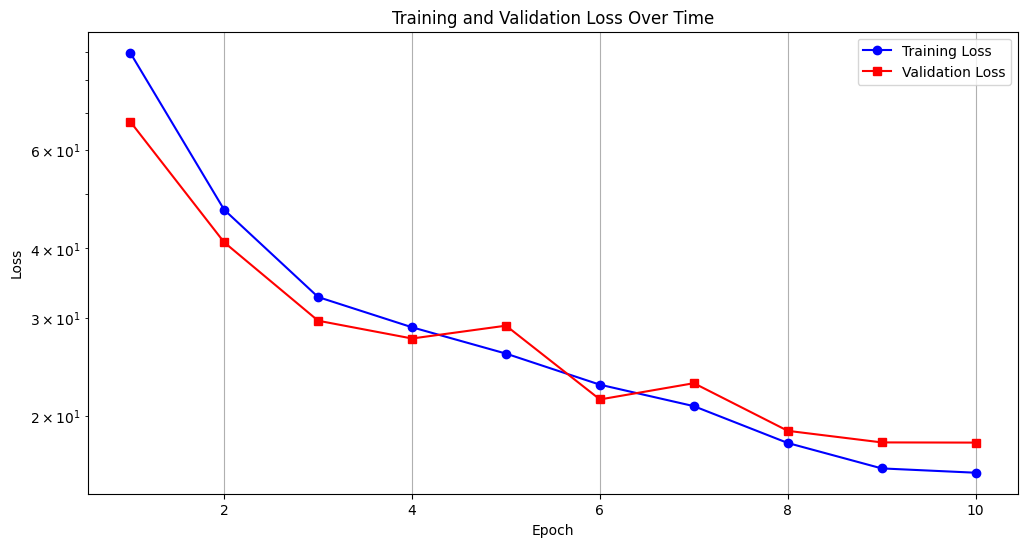

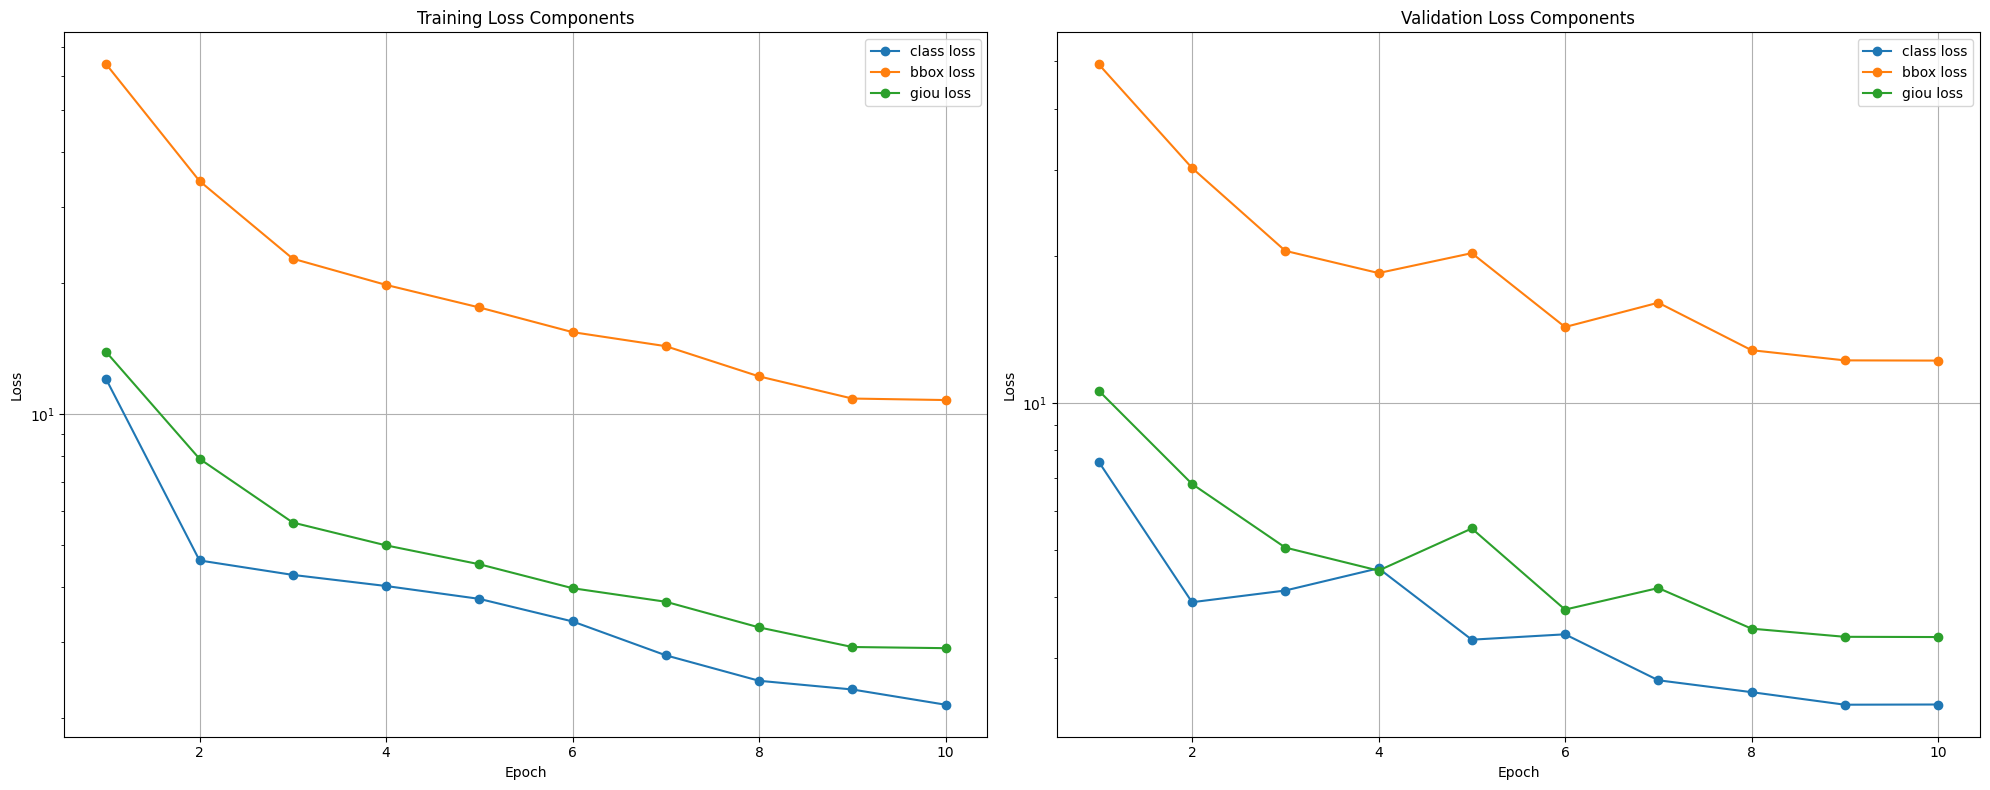

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

class TrainingAnalyzer:
    """Analyzes and visualizes training results"""

    def __init__(self):
        # Extract metrics from training output
        self.epochs = list(range(1, 11))
        self.train_losses = [89.6621, 46.8761, 32.6894, 28.8508, 25.8799,
                           22.7618, 20.8308, 17.8899, 16.1084, 15.8240]
        self.val_losses = [67.4683, 40.9776, 29.6442, 27.5447, 29.0442,
                          21.4157, 22.9024, 18.8118, 17.9342, 17.9200]

        # Component losses
        self.train_components = {
            'class': [12.0252, 4.6103, 4.2708, 4.0269, 3.7619, 3.3383, 2.7901, 2.4382, 2.3284, 2.1480],
            'bbox': [63.7470, 34.3682, 22.7835, 19.8305, 17.5993, 15.4431, 14.3360, 12.2171, 10.8646, 10.7785],
            'giou': [13.8899, 7.8976, 5.6350, 4.9934, 4.5187, 3.9804, 3.7047, 3.2346, 2.9154, 2.8976]
        }

        self.val_components = {
            'class': [7.5666, 3.9034, 4.1248, 4.5805, 3.2713, 3.3552, 2.7014, 2.5542, 2.4074, 2.4097],
            'bbox': [49.3187, 30.2556, 20.4683, 18.4327, 20.2461, 14.2904, 16.0277, 12.8116, 12.2109, 12.1981],
            'giou': [10.5830, 6.8186, 5.0511, 4.5314, 5.5268, 3.7701, 4.1733, 3.4460, 3.3159, 3.3122]
        }

    def plot_overall_losses(self):
        """Plot training and validation losses"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.epochs, self.train_losses, 'b-', label='Training Loss', marker='o')
        plt.plot(self.epochs, self.val_losses, 'r-', label='Validation Loss', marker='s')
        plt.title('Training and Validation Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')  # Using log scale for better visualization
        plt.show()

    def plot_component_losses(self):
        """Plot component-wise losses"""
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Training components
        for component in ['class', 'bbox', 'giou']:
            axes[0].plot(self.epochs, self.train_components[component],
                        marker='o', label=f'{component} loss')
        axes[0].set_title('Training Loss Components')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        axes[0].set_yscale('log')

        # Validation components
        for component in ['class', 'bbox', 'giou']:
            axes[1].plot(self.epochs, self.val_components[component],
                        marker='o', label=f'{component} loss')
        axes[1].set_title('Validation Loss Components')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_yscale('log')

        plt.tight_layout()
        plt.show()

    def compute_improvement_metrics(self):
        """Compute improvement metrics"""
        metrics = {
            'Initial Training Loss': self.train_losses[0],
            'Final Training Loss': self.train_losses[-1],
            'Training Loss Improvement': (1 - self.train_losses[-1]/self.train_losses[0]) * 100,
            'Initial Validation Loss': self.val_losses[0],
            'Final Validation Loss': self.val_losses[-1],
            'Validation Loss Improvement': (1 - self.val_losses[-1]/self.val_losses[0]) * 100,
            'Best Validation Loss': min(self.val_losses),
            'Best Validation Epoch': self.val_losses.index(min(self.val_losses)) + 1
        }

        return metrics

    def analyze_convergence(self):
        """Analyze training convergence"""
        # Calculate relative changes between epochs
        train_changes = np.diff(self.train_losses) / np.array(self.train_losses[:-1])
        val_changes = np.diff(self.val_losses) / np.array(self.val_losses[:-1])

        # Analyze stability in last few epochs
        last_epochs = 3
        train_stability = np.std(self.train_losses[-last_epochs:])
        val_stability = np.std(self.val_losses[-last_epochs:])

        analysis = {
            'Average Epoch-to-Epoch Improvement (Train)': np.mean(train_changes) * 100,
            'Average Epoch-to-Epoch Improvement (Val)': np.mean(val_changes) * 100,
            'Final Training Stability (std)': train_stability,
            'Final Validation Stability (std)': val_stability,
            'Converged': val_stability < 1.0  # Consider converged if std < 1.0
        }

        return analysis

if __name__ == "__main__":
    # Create analyzer and generate visualizations
    analyzer = TrainingAnalyzer()

    # Plot losses
    print("\n=== Loss Plots ===")
    analyzer.plot_overall_losses()
    analyzer.plot_component_losses()

    # Print improvement metrics
    print("\n=== Training Improvements ===")
    metrics = analyzer.compute_improvement_metrics()
    for key, value in metrics.items():
        if 'Improvement' in key:
            print(f"{key}: {value:.2f}%")
        else:
            print(f"{key}: {value:.4f}")

    # Print convergence analysis
    print("\n=== Convergence Analysis ===")
    analysis = analyzer.analyze_convergence()
    for key, value in analysis.items():
        if isinstance(value, bool):
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")



In [ ]:

import json
import os
from datetime import datetime
import seaborn as sns
from pathlib import Path

class TrainingResultsExporter:
    """Exports and saves training results and visualizations"""

    def __init__(self, config_path):
        self.config_path = Path(config_path)
        self.results_dir = self.config_path / 'training_results'
        self.results_dir.mkdir(parents=True, exist_ok=True)

        # Training metrics
        self.training_metrics = {
            'epochs': list(range(1, 11)),
            'train_losses': [89.6621, 46.8761, 32.6894, 28.8508, 25.8799,
                           22.7618, 20.8308, 17.8899, 16.1084, 15.8240],
            'val_losses': [67.4683, 40.9776, 29.6442, 27.5447, 29.0442,
                          21.4157, 22.9024, 18.8118, 17.9342, 17.9200],
            'train_components': {
                'class': [12.0252, 4.6103, 4.2708, 4.0269, 3.7619, 3.3383, 2.7901, 2.4382, 2.3284, 2.1480],
                'bbox': [63.7470, 34.3682, 22.7835, 19.8305, 17.5993, 15.4431, 14.3360, 12.2171, 10.8646, 10.7785],
                'giou': [13.8899, 7.8976, 5.6350, 4.9934, 4.5187, 3.9804, 3.7047, 3.2346, 2.9154, 2.8976]
            },
            'val_components': {
                'class': [7.5666, 3.9034, 4.1248, 4.5805, 3.2713, 3.3552, 2.7014, 2.5542, 2.4074, 2.4097],
                'bbox': [49.3187, 30.2556, 20.4683, 18.4327, 20.2461, 14.2904, 16.0277, 12.8116, 12.2109, 12.1981],
                'giou': [10.5830, 6.8186, 5.0511, 4.5314, 5.5268, 3.7701, 4.1733, 3.4460, 3.3159, 3.3122]
            }
        }

    def create_detailed_plots(self):
        """Create and save detailed training plots"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Set style
        plt.style.use('seaborn')
        sns.set_palette("husl")

        # 1. Overall Loss Plot
        plt.figure(figsize=(12, 6))
        plt.plot(self.training_metrics['epochs'], self.training_metrics['train_losses'],
                'b-', label='Training Loss', marker='o', linewidth=2)
        plt.plot(self.training_metrics['epochs'], self.training_metrics['val_losses'],
                'r-', label='Validation Loss', marker='s', linewidth=2)
        plt.title('Training and Validation Loss Over Time', fontsize=14, pad=20)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.tight_layout()
        plt.savefig(self.results_dir / f'overall_loss_{timestamp}.png', dpi=300, bbox_inches='tight')
        plt.close()

        # 2. Component Losses
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Detailed Loss Component Analysis', fontsize=16, y=1.02)

        # Training components absolute
        for component in ['class', 'bbox', 'giou']:
            axes[0, 0].plot(self.training_metrics['epochs'],
                          self.training_metrics['train_components'][component],
                          marker='o', label=f'{component} loss', linewidth=2)
        axes[0, 0].set_title('Training Loss Components (Absolute)', fontsize=12)
        axes[0, 0].set_xlabel('Epoch', fontsize=10)
        axes[0, 0].set_ylabel('Loss', fontsize=10)
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_yscale('log')

        # Validation components absolute
        for component in ['class', 'bbox', 'giou']:
            axes[0, 1].plot(self.training_metrics['epochs'],
                          self.training_metrics['val_components'][component],
                          marker='o', label=f'{component} loss', linewidth=2)
        axes[0, 1].set_title('Validation Loss Components (Absolute)', fontsize=12)
        axes[0, 1].set_xlabel('Epoch', fontsize=10)
        axes[0, 1].set_ylabel('Loss', fontsize=10)
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')

        # Training components relative
        total_train = np.array(self.training_metrics['train_losses'])
        for component in ['class', 'bbox', 'giou']:
            component_ratio = np.array(self.training_metrics['train_components'][component]) / total_train * 100
            axes[1, 0].plot(self.training_metrics['epochs'], component_ratio,
                          marker='o', label=f'{component} %', linewidth=2)
        axes[1, 0].set_title('Training Loss Components (Relative %)', fontsize=12)
        axes[1, 0].set_xlabel('Epoch', fontsize=10)
        axes[1, 0].set_ylabel('Percentage of Total Loss', fontsize=10)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)

        # Validation components relative
        total_val = np.array(self.training_metrics['val_losses'])
        for component in ['class', 'bbox', 'giou']:
            component_ratio = np.array(self.training_metrics['val_components'][component]) / total_val * 100
            axes[1, 1].plot(self.training_metrics['epochs'], component_ratio,
                          marker='o', label=f'{component} %', linewidth=2)
        axes[1, 1].set_title('Validation Loss Components (Relative %)', fontsize=12)
        axes[1, 1].set_xlabel('Epoch', fontsize=10)
        axes[1, 1].set_ylabel('Percentage of Total Loss', fontsize=10)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.results_dir / f'component_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def export_training_summary(self):
        """Export detailed training summary"""
        # Calculate final metrics
        final_metrics = {
            'training_summary': {
                'initial_train_loss': self.training_metrics['train_losses'][0],
                'final_train_loss': self.training_metrics['train_losses'][-1],
                'train_improvement': (1 - self.training_metrics['train_losses'][-1] /
                                    self.training_metrics['train_losses'][0]) * 100,
                'initial_val_loss': self.training_metrics['val_losses'][0],
                'final_val_loss': self.training_metrics['val_losses'][-1],
                'val_improvement': (1 - self.training_metrics['val_losses'][-1] /
                                  self.training_metrics['val_losses'][0]) * 100,
                'best_val_loss': min(self.training_metrics['val_losses']),
                'best_val_epoch': self.training_metrics['val_losses'].index(
                    min(self.training_metrics['val_losses'])) + 1
            },
            'component_analysis': {
                'training': {
                    comp: {
                        'initial': values[0],
                        'final': values[-1],
                        'improvement': (1 - values[-1] / values[0]) * 100
                    }
                    for comp, values in self.training_metrics['train_components'].items()
                },
                'validation': {
                    comp: {
                        'initial': values[0],
                        'final': values[-1],
                        'improvement': (1 - values[-1] / values[0]) * 100
                    }
                    for comp, values in self.training_metrics['val_components'].items()
                }
            },
            'convergence_analysis': {
                'final_epochs_stability': {
                    'train': float(np.std(self.training_metrics['train_losses'][-3:])),
                    'val': float(np.std(self.training_metrics['val_losses'][-3:]))
                },
                'epoch_to_epoch_improvement': {
                    'train': float(np.mean(np.diff(self.training_metrics['train_losses']) /
                                         np.array(self.training_metrics['train_losses'][:-1])) * 100),
                    'val': float(np.mean(np.diff(self.training_metrics['val_losses']) /
                                       np.array(self.training_metrics['val_losses'][:-1])) * 100)
                }
            }
        }

        # Save metrics
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        with open(self.results_dir / f'training_summary_{timestamp}.json', 'w') as f:
            json.dump(final_metrics, f, indent=4)

        return final_metrics

if __name__ == "__main__":
    exporter = TrainingResultsExporter("/content/drive/MyDrive/CV/CV_assignment")

    # Create detailed plots
    print("\n=== Creating Detailed Visualizations ===")
    exporter.create_detailed_plots()
    print("✓ Plots saved successfully")

    # Export training summary
    print("\n=== Exporting Training Summary ===")
    summary = exporter.export_training_summary()

    # Print formatted summary
    print("\nFinal Training Summary:")
    print("=" * 50)
    print(f"Training Loss Improvement: {summary['training_summary']['train_improvement']:.2f}%")
    print(f"Validation Loss Improvement: {summary['training_summary']['val_improvement']:.2f}%")
    print("\nComponent-wise Improvements:")
    for component in ['class', 'bbox', 'giou']:
        print(f"\n{component.upper()} Loss:")
        print(f"  Training: {summary['component_analysis']['training'][component]['improvement']:.2f}%")
        print(f"  Validation: {summary['component_analysis']['validation'][component]['improvement']:.2f}%")

    print("\nConvergence Analysis:")
    print(f"Final Training Stability: {summary['convergence_analysis']['final_epochs_stability']['train']:.4f}")
    print(f"Final Validation Stability: {summary['convergence_analysis']['final_epochs_stability']['val']:.4f}")




=== Creating Detailed Visualizations ===


<ipython-input-18-78eaec2b5f73>:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


✓ Plots saved successfully

=== Exporting Training Summary ===

Final Training Summary:
Training Loss Improvement: 82.35%
Validation Loss Improvement: 73.44%

Component-wise Improvements:

CLASS Loss:
  Training: 82.14%
  Validation: 68.15%

BBOX Loss:
  Training: 83.09%
  Validation: 75.27%

GIOU Loss:
  Training: 79.14%
  Validation: 68.70%

Convergence Analysis:
Final Training Stability: 0.9142
Final Validation Stability: 0.4171


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-14-512cafc76c1e>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta


=== Generating Multi-scale Attention Maps ===

Initializing DeformableAttentionVisualizer...
Device: cuda
Output directory: /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps

Processing image 1/5: /content/drive/MyDrive/CV/CV_assignment/validation/8794.jpg

Processing image: /content/drive/MyDrive/CV/CV_assignment/validation/8794.jpg
Processing feature scales:
Scale 1: torch.Size([1, 256, 60, 80]) -> torch.Size([1, 1, 480, 640])
Scale 2: torch.Size([1, 256, 30, 40]) -> torch.Size([1, 1, 480, 640])
Scale 3: torch.Size([1, 256, 15, 20]) -> torch.Size([1, 1, 480, 640])
Saved visualization to /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps/attention_0.png


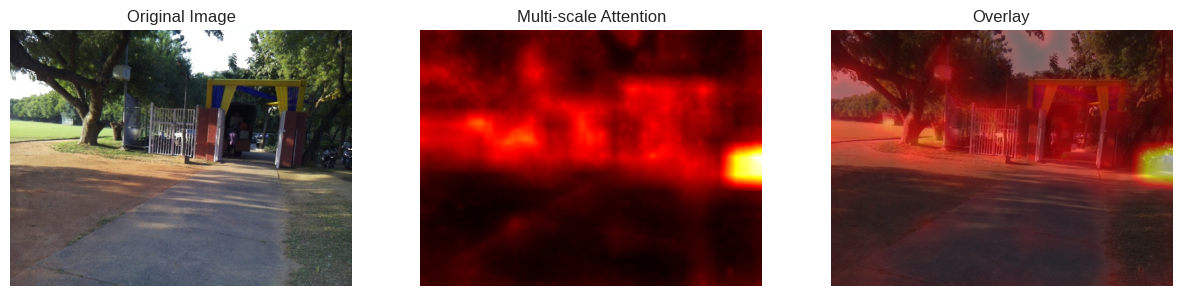


Processing image 2/5: /content/drive/MyDrive/CV/CV_assignment/validation/6276.jpg

Processing image: /content/drive/MyDrive/CV/CV_assignment/validation/6276.jpg
Processing feature scales:
Scale 1: torch.Size([1, 256, 60, 80]) -> torch.Size([1, 1, 480, 640])
Scale 2: torch.Size([1, 256, 30, 40]) -> torch.Size([1, 1, 480, 640])
Scale 3: torch.Size([1, 256, 15, 20]) -> torch.Size([1, 1, 480, 640])
Saved visualization to /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps/attention_1.png


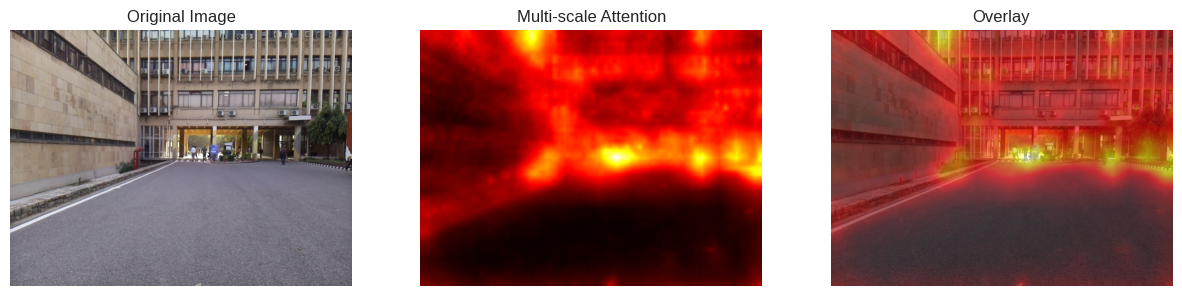


Processing image 3/5: /content/drive/MyDrive/CV/CV_assignment/validation/10990.jpg

Processing image: /content/drive/MyDrive/CV/CV_assignment/validation/10990.jpg
Processing feature scales:
Scale 1: torch.Size([1, 256, 60, 80]) -> torch.Size([1, 1, 480, 640])
Scale 2: torch.Size([1, 256, 30, 40]) -> torch.Size([1, 1, 480, 640])
Scale 3: torch.Size([1, 256, 15, 20]) -> torch.Size([1, 1, 480, 640])
Saved visualization to /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps/attention_2.png


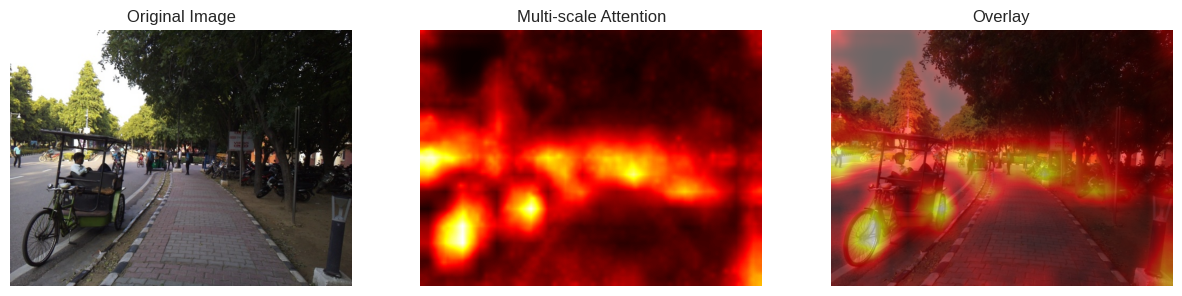


Processing image 4/5: /content/drive/MyDrive/CV/CV_assignment/validation/11273.jpg

Processing image: /content/drive/MyDrive/CV/CV_assignment/validation/11273.jpg
Processing feature scales:
Scale 1: torch.Size([1, 256, 60, 80]) -> torch.Size([1, 1, 480, 640])
Scale 2: torch.Size([1, 256, 30, 40]) -> torch.Size([1, 1, 480, 640])
Scale 3: torch.Size([1, 256, 15, 20]) -> torch.Size([1, 1, 480, 640])
Saved visualization to /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps/attention_3.png


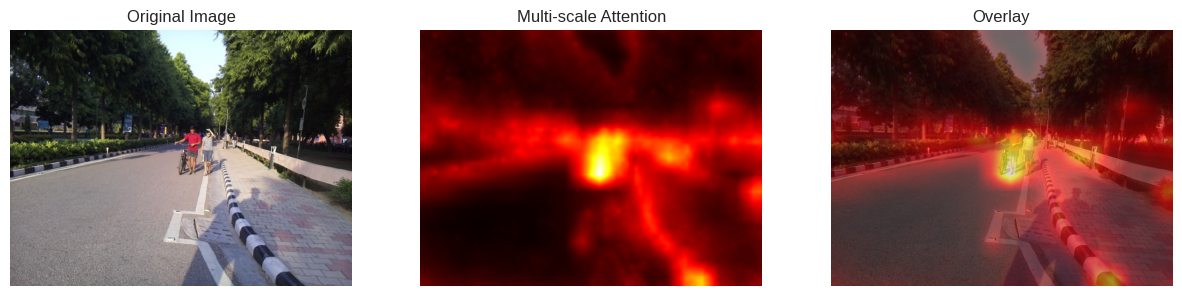


Processing image 5/5: /content/drive/MyDrive/CV/CV_assignment/validation/13038.jpg

Processing image: /content/drive/MyDrive/CV/CV_assignment/validation/13038.jpg
Processing feature scales:
Scale 1: torch.Size([1, 256, 60, 80]) -> torch.Size([1, 1, 480, 640])
Scale 2: torch.Size([1, 256, 30, 40]) -> torch.Size([1, 1, 480, 640])
Scale 3: torch.Size([1, 256, 15, 20]) -> torch.Size([1, 1, 480, 640])
Saved visualization to /content/drive/MyDrive/CV/CV_assignment/DINO_finetune/attention_maps/attention_4.png


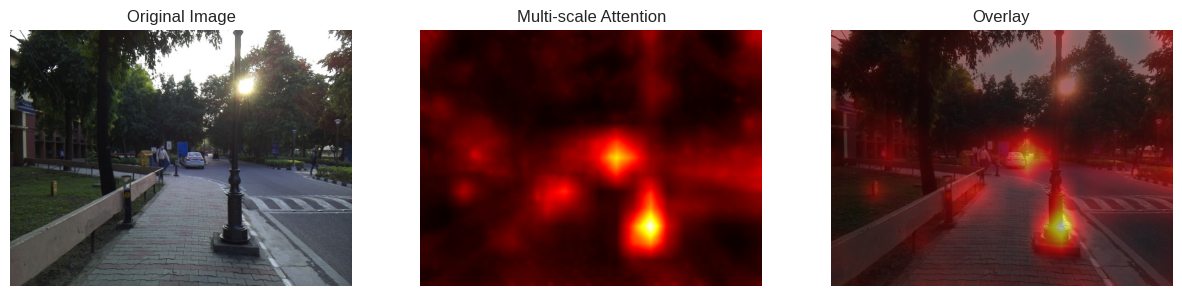

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import os
import numpy as np
from pathlib import Path
from util.misc import NestedTensor
class DeformableAttentionVisualizer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config.device
        self.attention_dir = Path(config.output_path) / 'attention_maps'
        self.attention_dir.mkdir(parents=True, exist_ok=True)

        # Create projection layers for different scales
        self.proj_layers = self._create_projection_layers()

        print("\nInitializing DeformableAttentionVisualizer...")
        print(f"Device: {self.device}")
        print(f"Output directory: {self.attention_dir}")

        self.transform = T.Compose([
            T.Resize((480, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
        ])

    def _create_projection_layers(self):
        """Create projection layers to handle different channel dimensions"""
        proj_layers = torch.nn.ModuleDict({
            'layer1': torch.nn.Conv2d(512, 256, kernel_size=1),
            'layer2': torch.nn.Conv2d(1024, 256, kernel_size=1),
            'layer3': torch.nn.Conv2d(2048, 256, kernel_size=1)
        }).to(self.device)
        return proj_layers

    def process_feature_map(self, feat_map, layer_name):
        """Process a single feature map"""
        if isinstance(feat_map, torch.Tensor):
            src = feat_map
        else:
            src = feat_map.tensors

        with torch.no_grad():  # Add no_grad here to prevent gradient computation
            # Project to same channel dimension
            src = self.proj_layers[layer_name](src)

            # Create mask if needed
            if isinstance(feat_map, torch.Tensor):
                mask = torch.zeros((src.shape[0], src.shape[2], src.shape[3]),
                                dtype=torch.bool, device=self.device)
            else:
                mask = feat_map.mask

            return src, mask

    def visualize_attention(self, image_path, save_name=None):
        """Visualize attention maps"""
        print(f"\nProcessing image: {image_path}")

        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)

            with torch.no_grad():  # Add no_grad context for the entire processing
                nested_tensor = NestedTensor(
                    image_tensor,
                    torch.zeros(1, 480, 640, dtype=torch.bool, device=self.device)
                )

                # Get backbone features
                features = self.model.backbone(nested_tensor)
                if isinstance(features, tuple):
                    features = features[0]

                # Process each feature level
                processed_features = []
                attention_maps = []

                print("Processing feature scales:")
                for idx, (feat, layer_name) in enumerate(zip(features, ['layer1', 'layer2', 'layer3'])):
                    # Project and process feature map
                    feat_proj, mask = self.process_feature_map(feat, layer_name)
                    processed_features.append(feat_proj)

                    # Calculate attention map for this scale
                    attention = feat_proj.pow(2).sum(1)  # Simple channel-wise attention
                    attention = F.interpolate(
                        attention.unsqueeze(1),
                        size=(480, 640),
                        mode='bilinear',
                        align_corners=False
                    )
                    attention_maps.append(attention)
                    print(f"Scale {idx + 1}: {feat_proj.shape} -> {attention.shape}")

                # Combine attention maps from all scales
                combined_attention = torch.stack(attention_maps).mean(0)
                # Use detach() before converting to numpy
                attention_map = combined_attention.squeeze().detach().cpu().numpy()
                attention_map = (attention_map - attention_map.min()) / \
                              (attention_map.max() - attention_map.min() + 1e-8)

                # Create visualization
                plt.figure(figsize=(15, 5))

                # Original image
                plt.subplot(131)
                plt.imshow(image)
                plt.title('Original Image')
                plt.axis('off')

                # Attention map
                plt.subplot(132)
                plt.imshow(attention_map, cmap='hot')
                plt.title('Multi-scale Attention')
                plt.axis('off')

                # Overlay
                plt.subplot(133)
                plt.imshow(image)
                plt.imshow(attention_map, alpha=0.6, cmap='hot')
                plt.title('Overlay')
                plt.axis('off')

                # Save visualization
                if save_name:
                    save_path = self.attention_dir / f'{save_name}.png'
                    plt.savefig(save_path, bbox_inches='tight', dpi=300)
                    print(f"Saved visualization to {save_path}")

                plt.show()
                plt.close()

        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            import traceback
            traceback.print_exc()

def generate_attention_maps(model, config):
    """Generate attention maps for validation images"""
    print("\n=== Generating Multi-scale Attention Maps ===")
    visualizer = DeformableAttentionVisualizer(model, config)

    # Get validation images
    val_path = Path(config.val_path)
    image_paths = list(val_path.glob('*.jpg')) + list(val_path.glob('*.png'))

    if not image_paths:
        print("No images found in validation directory!")
        return

    # Process images
    num_images = min(5, len(image_paths))
    for idx, image_path in enumerate(image_paths[:num_images]):
        print(f"\nProcessing image {idx+1}/{num_images}: {image_path}")
        visualizer.visualize_attention(str(image_path), f'attention_{idx}')

if __name__ == "__main__":
    # Initialize model and configuration
    config = AdvancedTrainingConfig().setup()
    model, criterion, postprocessors, ema_model = setup_model(config)

    # Generate attention maps
    generate_attention_maps(model, config)

# SETTING UP AND EVALUATION DINO-FINETUNE MODEL

In [ ]:

"""
Set up all necessary imports and define paths
"""
import torch
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from pathlib import Path
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Define base paths
BASE_PATH = "/content/drive/MyDrive/CV/CV_assignment"
DINO_PATH = os.path.join(BASE_PATH, "DINO")
MODEL_PATH = os.path.join(BASE_PATH, "DINO_finetune/models/best_model.pth")
VALIDATION_DIR = os.path.join(BASE_PATH, "validation")
ANNOTATION_PATH = os.path.join(BASE_PATH, "random_sample_mavi_2_gt.json")
OUTPUT_DIR = os.path.join(BASE_PATH, "evaluation_results")

# Add DINO to Python path
if DINO_PATH not in sys.path:
    sys.path.append(DINO_PATH)

# Verify paths exist
print("=== Path Verification ===")
print(f"DINO path exists: {os.path.exists(DINO_PATH)}")
print(f"Model path exists: {os.path.exists(MODEL_PATH)}")
print(f"Validation directory exists: {os.path.exists(VALIDATION_DIR)}")
print(f"Annotation file exists: {os.path.exists(ANNOTATION_PATH)}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\nOutput directory created at: {OUTPUT_DIR}")

=== Path Verification ===
DINO path exists: True
Model path exists: False
Validation directory exists: True
Annotation file exists: True

Output directory created at: /content/drive/MyDrive/CV/CV_assignment/evaluation_results


In [ ]:
import sys
import torch
from pathlib import Path
import logging
from dataclasses import dataclass
import numpy as np

@dataclass
class ModelConfig:
    """Configuration for DINO model inference"""
    # Paths
    model_path: str = "/content/drive/MyDrive/CV/CV_assignment/DINO_finetune/models/best_model.pth"
    output_dir: str = "/content/drive/MyDrive/CV/CV_assignment/DINO_finetune_output"
    val_path: str = "/content/drive/MyDrive/CV/CV_assignment/validation"
    gt_path: str = "/content/drive/MyDrive/CV/CV_assignment/random_sample_mavi_2_gt.json"
    dino_path: str = "/content/drive/MyDrive/CV/CV_assignment/DINO"

    # Model parameters
    num_classes: int = 2  # background + pedestrian
    hidden_dim: int = 256
    num_feature_levels: int = 4
    enc_layers: int = 6
    dec_layers: int = 6
    dim_feedforward: int = 2048
    nheads: int = 8
    num_queries: int = 900

    # Inference parameters
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    confidence_threshold: float = 0.3

    def setup(self):
        """Setup output directories and logging"""
        # Create output directory
        output_dir = Path(self.output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        return self

def load_fine_tuned_model(config):
    """Load the fine-tuned DINO model"""
    try:
        logging.info("Loading fine-tuned model...")

        # Add DINO to Python path if not already added
        if config.dino_path not in sys.path:
            sys.path.append(config.dino_path)
            logging.info(f"Added DINO path to system path: {config.dino_path}")

        # Import DINO-specific modules
        from models.dino.dino import build_dino
        from util.slconfig import SLConfig

        # Load base DINO config
        config_path = Path(config.dino_path) / "config/DINO/DINO_4scale.py"
        args = SLConfig.fromfile(config_path)
        logging.info(f"Loaded base config from: {config_path}")

        # Update configuration with our parameters
        args.num_classes = config.num_classes
        args.hidden_dim = config.hidden_dim
        args.num_feature_levels = config.num_feature_levels
        args.enc_layers = config.enc_layers
        args.dec_layers = config.dec_layers
        args.dim_feedforward = config.dim_feedforward
        args.nheads = config.nheads
        args.num_queries = config.num_queries
        args.device = config.device

        # Print key configuration parameters
        logging.info("\nModel Configuration:")
        for key in ['num_classes', 'hidden_dim', 'num_feature_levels',
                   'enc_layers', 'dec_layers', 'num_queries']:
            logging.info(f"{key}: {getattr(args, key)}")

        # Build model
        logging.info("\nBuilding DINO model...")
        model, criterion, postprocessors = build_dino(args)

        # Load checkpoint
        logging.info(f"\nLoading checkpoint from: {config.model_path}")
        checkpoint = torch.load(config.model_path, map_location=config.device)

        # Load model weights
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
            logging.info("Found model_state_dict in checkpoint")
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
            logging.info("Found model weights in checkpoint")
        else:
            raise KeyError("Could not find model weights in checkpoint")

        # Load state dict
        missing, unexpected = model.load_state_dict(state_dict, strict=False)

        if missing:
            logging.warning(f"Missing keys: {missing}")
        if unexpected:
            logging.warning(f"Unexpected keys: {unexpected}")

        # Move model to device and set to eval mode
        model = model.to(config.device)
        model.eval()

        logging.info("Model loaded successfully!")

        return model, postprocessors

    except Exception as e:
        logging.error(f"Error loading model: {str(e)}")
        raise

if __name__ == "__main__":
    print("\nStarting model setup...")

    # Initialize configuration
    config = ModelConfig().setup()

    try:
        # Load model
        model, postprocessors = load_fine_tuned_model(config)

        # Print model summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print("\nModel Summary:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model device: {next(model.parameters()).device}")

        # Test if model is in eval mode
        print(f"\nModel is in eval mode: {not model.training}")

        # Print model's device distribution
        devices = set(p.device for p in model.parameters())
        print(f"Model parameters are on devices: {devices}")

        print("\nModel setup completed successfully!")

    except Exception as e:
        print(f"\nError during setup: {str(e)}")
        import traceback
        traceback.print_exc()


Starting model setup...


<ipython-input-22-c6c3daf3f2c5>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.model_path, map_location=config.device)



Model Summary:
Total parameters: 46,847,436
Trainable parameters: 46,625,036
Model device: cuda:0

Model is in eval mode: True
Model parameters are on devices: {device(type='cuda', index=0)}

Model setup completed successfully!


In [ ]:
import os
import torch
import numpy as np
import cv2
from PIL import Image
import json
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as T
from util.misc import NestedTensor

class DINOInference:
    def __init__(self, model, postprocessors, config):
        self.model = model
        self.postprocessors = postprocessors
        self.config = config
        self.device = config.device
        self.transform = self._get_transforms()

        # Create output directories
        self.output_dir = Path(config.output_dir)
        self.vis_dir = self.output_dir / "visualizations"
        self.vis_dir.mkdir(parents=True, exist_ok=True)

        print("\nInitialized DINO Inference Pipeline")
        print(f"Output directory: {self.output_dir}")
        print(f"Visualization directory: {self.vis_dir}")

    def _get_transforms(self):
        """Original DINO transforms"""
        return T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def prepare_image(self, image):
        """Prepare image for inference maintaining aspect ratio"""
        # Get original size
        w, h = image.size

        # Compute new size (max 800 on longer side)
        r = 800.0 / max(w, h)
        if r < 1:  # Only resize if image is larger than 800
            new_w, new_h = int(w * r), int(h * r)
            image = image.resize((new_w, new_h), Image.BILINEAR)

        # Convert to tensor and normalize
        img_tensor = self.transform(image)

        return img_tensor, (w, h)

    def run_inference(self):
        """Run inference on validation images"""
        validation_dir = Path(self.config.val_path)
        validation_files = sorted(list(validation_dir.glob('*.jpg')) +
                                list(validation_dir.glob('*.jpeg')) +
                                list(validation_dir.glob('*.png')))

        print(f"\nFound {len(validation_files)} validation images")
        results = []

        for idx, img_file in enumerate(tqdm(validation_files, desc="Processing")):
            try:
                # Load and prepare image
                image = Image.open(img_file).convert('RGB')
                img_tensor, orig_size = self.prepare_image(image)

                # Add batch dimension and move to device
                img_tensor = img_tensor.unsqueeze(0).to(self.device)

                # Create mask for padding
                mask = torch.zeros(1, img_tensor.shape[2], img_tensor.shape[3],
                                 dtype=torch.bool).to(self.device)

                # Create nested tensor
                nested_tensor = NestedTensor(img_tensor, mask)

                # Run inference
                with torch.no_grad():
                    outputs = self.model(nested_tensor)

                # Post-process with original size
                processed = self.postprocessors['bbox'](
                    outputs,
                    torch.tensor([[orig_size[1], orig_size[0]]]).to(self.device)
                )[0]

                # Filter predictions
                scores = processed['scores']
                keep = scores > 0.3  # Original threshold
                boxes = processed['boxes'][keep]
                scores = scores[keep]
                labels = processed['labels'][keep]

                # Store results
                results.append({
                    'image_id': img_file.stem,
                    'boxes': boxes.cpu().numpy().tolist(),
                    'scores': scores.cpu().numpy().tolist(),
                    'labels': labels.cpu().numpy().tolist()
                })

                # Visualize predictions
                image_np = np.array(image)
                for box, score in zip(boxes.cpu(), scores.cpu()):
                    x1, y1, x2, y2 = box.tolist()
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

                    cv2.rectangle(image_np,
                                (x1, y1),
                                (x2, y2),
                                (0, 255, 0), 2)

                    label_text = f'pedestrian {score:.2f}'
                    cv2.putText(image_np,
                              label_text,
                              (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.5,
                              (0, 255, 0),
                              2)

                # Save visualization
                output_path = self.vis_dir / f'pred_{img_file.name}'
                cv2.imwrite(str(output_path), cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print(f"\nError processing image {img_file}: {str(e)}")
                continue

        # Convert to COCO format for evaluation
        coco_results = []
        for result in results:
            image_id = result['image_id']

            for box, score, label in zip(result['boxes'], result['scores'], result['labels']):
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1

                coco_results.append({
                    'image_id': image_id,
                    'category_id': int(label),
                    'bbox': [float(x1), float(y1), float(width), float(height)],
                    'score': float(score)
                })

        return coco_results

def run_validation_inference(model, postprocessors, config):
    """Run validation inference and save results"""
    print("\nInitializing validation inference...")

    try:
        # Create inference pipeline
        inferencer = DINOInference(model, postprocessors, config)

        # Run inference
        results = inferencer.run_inference()

        # Save results
        results_path = Path(config.output_dir) / "inference_results.json"
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"\nResults saved to: {results_path}")
        print(f"Total detections: {len(results)}")

        return results

    except Exception as e:
        print(f"\nError during inference: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    # Initialize configuration
    config = ModelConfig().setup()

    try:
        # Load model
        model, postprocessors = load_fine_tuned_model(config)

        # Run inference
        results = run_validation_inference(model, postprocessors, config)

        if results is not None:
            print("\nInference completed successfully!")
            print(f"Total detections: {len(results)}")

    except Exception as e:
        print(f"\nError during setup: {str(e)}")
        import traceback
        traceback.print_exc()

<ipython-input-22-c6c3daf3f2c5>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.model_path, map_location=config.device)



Initializing validation inference...

Initialized DINO Inference Pipeline
Output directory: /content/drive/MyDrive/CV/CV_assignment/DINO_finetune_output
Visualization directory: /content/drive/MyDrive/CV/CV_assignment/DINO_finetune_output/visualizations

Found 40 validation images


Processing: 100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Results saved to: /content/drive/MyDrive/CV/CV_assignment/DINO_finetune_output/inference_results.json
Total detections: 489

Inference completed successfully!
Total detections: 489
